# Background and Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

Objective

To predict whether a liability customer will buy a personal loan or not.
Which variables are most significant.
Which segment of customers should be targeted more.

Data Dictionary
* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIP Code: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?



The goal of this project is to create a profile for what kinds of customers were more likely to buy a personal loan last campaign. To accomplish this goal, we will run a logistic regression and build a decision tree to get the most important features. The most important measure of model success will be recall as the cost of missing a potential customer is higher than soliciting someone who is uninterested. Recall is followed closely by accuracy. Ideally, we want false negatives to be as close to zero as possible while maintaining a high accuracy. We'll be using AUC-ROC curves to fine-tune the models.

Once we have a list of the important features, we should be able to advise the marketing department on what sorts of people are most likely to respond to the marketing techniques they used last year. That way they can develop other marketing techniques to expand the number of customers who take the loan while continuing to have success with the identified group.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# Libraries to help with model building
from sklearn.linear_model import LogisticRegression

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV

#For imputing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#For dealing with ZIPCodes
import uszipcode as zp
from uszipcode import SearchEngine

# to plot the performance with addition of each feature
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    plot_confusion_matrix,
    make_scorer,)
import shap


# Preprocessing

In [2]:
#Load the data
data = pd.read_csv("Loan_Modelling.csv")

In [3]:
#make a copy of the data so we can load the original if we want.
df = data.copy()

In [4]:
#Examine shape/size of the df
df.shape

(5000, 14)

That's 5000 entries with 14 different variables, all of which are described above in the data dictionary.

In [5]:
#Take a peek at what the df
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


First, the ID column is suspicious. I think it too much of a coincidence that a customer's ID just happens to be the same as their index position plus one. This entire column is probably meaningless.

Otherwise, it seems like everything has already been encoded for modeling. None of the variables seem to have strings in the columns. I'll double check.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Even the categorical variables are numbers here, which makes it easier to work with later.

For reference, the following columns are not categorical:

1. CCAvg
2. Mortgage
3. Age
4. Experience
5. Income
6. Family (can be categorical or not, our choice)

From the above we can also see there are no obvious null values: every column has 5000 entries. The next step is to see if there are duplicates.

In [7]:
#I can't trust ID, so I'm going to drop it.
df.drop(['ID'],axis=1,inplace=True)
#Now that ID is dropped, let's check for duplicates.
data.duplicated().sum()

0

There are no duplicates. Now let's check what each of the categorical variables have in them.

In [8]:
cat_columns = ['ZIPCode',
               'Family', #Going ahead and treating Family as categorical for now
               'Education',
               'Personal_Loan',
               'Securities_Account',
               'CD_Account',
               'Online',
               'CreditCard']
# Printing number of count of each unique value in each column
for column in cat_columns:
    print(df[column].value_counts())
    print("-" * 40)

94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
94087      1
96145      1
90068      1
92694      1
94404      1
Name: ZIPCode, Length: 467, dtype: int64
----------------------------------------
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
----------------------------------------
1    2096
3    1501
2    1403
Name: Education, dtype: int64
----------------------------------------
0    4520
1     480
Name: Personal_Loan, dtype: int64
----------------------------------------
0    4478
1     522
Name: Securities_Account, dtype: int64
----------------------------------------
0    4698
1     302
Name: CD_Account, dtype: int64
----------------------------------------
1    2984
0    2016
Name: Online, dtype: int64
----------------------------------------
0    3530
1    1470
Name: CreditCard, dtype: int64
----------------------------------------


ZIPCode will need to be dealt with before I run a regression. It has too many categories, if I one-hot it it will explode the complexity of the model. It can be left the way it is for a decision tree.

There are seemingly no hidden null values either, all of the entries make sense so far. I'll double check ZIPCode when I deal with it later. It could have a 00000 hidden in there or something.

I'll also get the univariate descriptive statistics for the numerical columns later to double check for shenanigans.

## Univariate Analysis & Preprocessing

In [9]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [10]:
#Separating out the numerical columns
num_cols = []
for column in df.columns:
    if column not in cat_columns:
        num_cols.append(column)
num_cols.append('Family') #Adding family in, just in case we want to keep it
num_cols

['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family']

In [11]:
#Let's get the descriptive stats for these columns
df[num_cols].describe().round(1)

,Age,Experience,Income,CCAvg,Mortgage,Family
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,45.3,20.1,73.8,1.9,56.5,2.4
std,11.5,11.5,46.0,1.7,101.7,1.1
min,23.0,-3.0,8.0,0.0,0.0,1.0
25%,35.0,10.0,39.0,0.7,0.0,1.0
50%,45.0,20.0,64.0,1.5,0.0,2.0
75%,55.0,30.0,98.0,2.5,101.0,3.0
max,67.0,43.0,224.0,10.0,635.0,4.0


The descriptive statistics of the continuous numerical columns already show some issues. There should not be negative values for Experience, for example. I will deal with these columns one at a time.

I want to see how skewed things are, look for outliers, and confirm there are no hidden missing values.

### Observations on Age

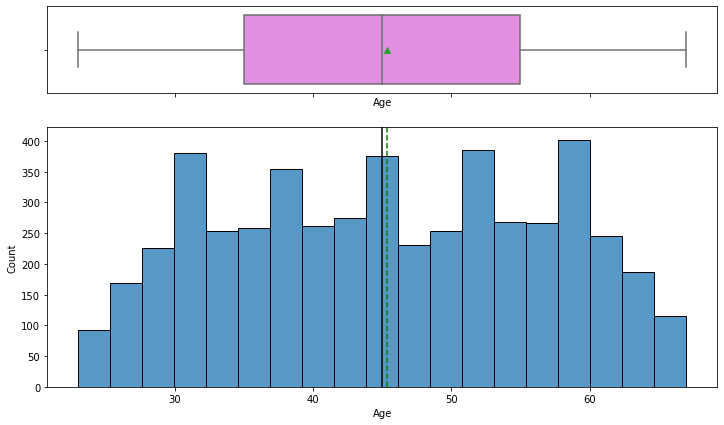

In [12]:
histogram_boxplot(df, 'Age')

Age ranges from 23 to 67 and is fairly evenly distributed. There seem to be no large outliers.

### Observations on Experience

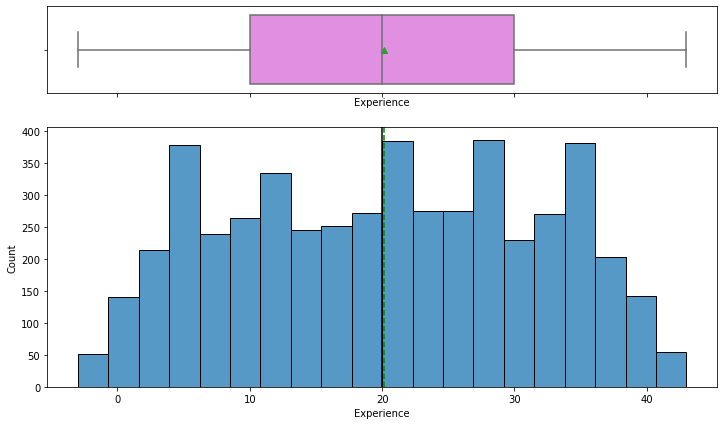

In [13]:
histogram_boxplot(df, 'Experience')

Experience should not have negative values. That makes no sense.

In [14]:
df[df['Experience'] < 0]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0
536,25,-1,43,92173,3,2.40,2,176,0,0,0,1,0
540,25,-1,109,94010,4,2.30,3,314,0,0,0,1,0
576,25,-1,48,92870,3,0.30,3,0,0,0,0,0,1
583,24,-1,38,95045,2,1.70,2,0,0,0,0,1,0
597,24,-2,125,92835,2,7.20,1,0,0,1,0,0,1


These entries make no sense. A 25 year old making 101k a year with -1 years professional experience and only an undergrad degree?

I'm going to treat these years of experience as missing values and impute them using KNN. 

In [15]:
#This replaces all those negative values with NaN
for i,row in df.iterrows():
    if df.at[i,'Experience']<0:
        df.replace(to_replace=df.at[i,'Experience'], value=np.nan, inplace=True)

In [16]:
#I want to pick the best size for the parameter K, so I'm going to iterate through some options.
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 1): #Iterating through K values 1-20.
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds) #Comparing the value of k by how low RMSE gets.
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [17]:
optimize_k(df,'Experience')

[{'K': 1, 'RMSE': 1.349559594830847},
 {'K': 2, 'RMSE': 1.3487919409605027},
 {'K': 3, 'RMSE': 1.394382858312435},
 {'K': 4, 'RMSE': 1.3010301999761573},
 {'K': 5, 'RMSE': 1.2992523219144154},
 {'K': 6, 'RMSE': 1.29902289989224},
 {'K': 7, 'RMSE': 1.295261852810828},
 {'K': 8, 'RMSE': 1.302313283161928},
 {'K': 9, 'RMSE': 1.2727270153318644},
 {'K': 10, 'RMSE': 1.2464195072286057},
 {'K': 11, 'RMSE': 1.2398909466175374},
 {'K': 12, 'RMSE': 1.2884826476648157},
 {'K': 13, 'RMSE': 1.3139978182143948},
 {'K': 14, 'RMSE': 1.2895659734965093},
 {'K': 15, 'RMSE': 1.2751926651817496},
 {'K': 16, 'RMSE': 1.2717193918938052},
 {'K': 17, 'RMSE': 1.3086614023841177},
 {'K': 18, 'RMSE': 1.3068215126976535},
 {'K': 19, 'RMSE': 1.2968324556416453}]

We see here that the lowest RMSE occurs at k=10, so we'll impute using that.

In [18]:
#Actually doing the imputation now.
imputer = KNNImputer(n_neighbors=10)
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

In [19]:
#Checking to ensure the value was actually imputed. 89 was originally -1.
df.iloc[89]

Age                      25.0
Experience                4.6
Income                  113.0
ZIPCode               94303.0
Family                    4.0
CCAvg                     2.3
Education                 3.0
Mortgage                  0.0
Personal_Loan             0.0
Securities_Account        0.0
CD_Account                0.0
Online                    0.0
CreditCard                1.0
Name: 89, dtype: float64

4.6 is a much better value compared to -1. One concern is that all of the rest of the numbers are whole numbers, but 4.6 makes sense given the context. I don't see any need to round.

Let's look at the histogram again.

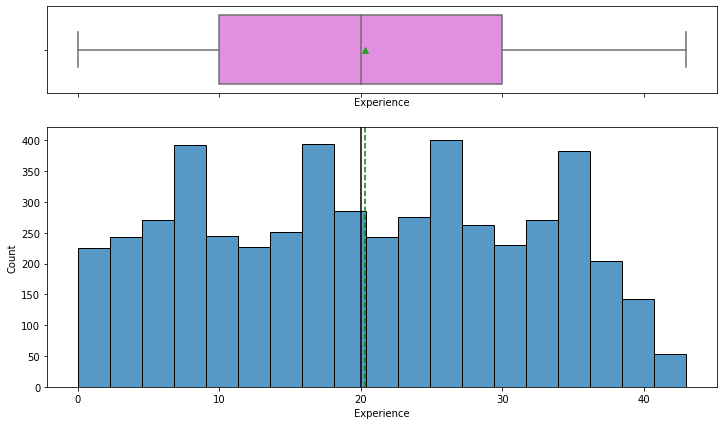

In [20]:
histogram_boxplot(df, 'Experience')

In [21]:
df['Experience'].describe().round()

count    5000.0
mean       20.0
std        11.0
min         0.0
25%        10.0
50%        20.0
75%        30.0
max        43.0
Name: Experience, dtype: float64

I changed the std by .5 but the 25%, 50%, and 75% are the same as before. Overall it still looks fairly well distributed.

### Observations on Income

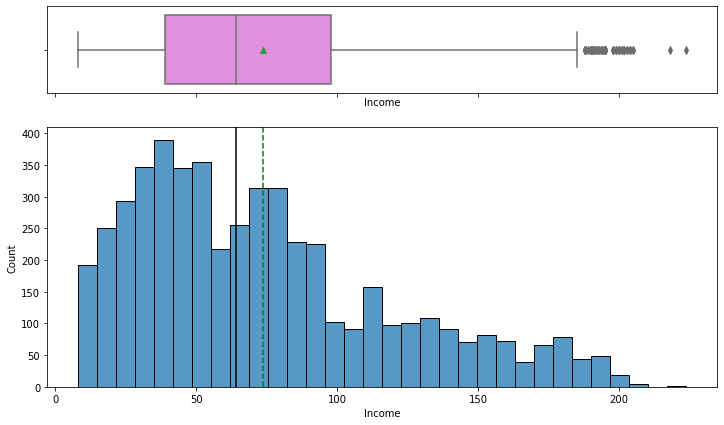

In [22]:
histogram_boxplot(df, 'Income')

In [23]:
print("Column: Income has skewness ",df['Income'].skew())

Column: Income has skewness  0.8413386072610816


My read on this is that there is only a little bit of skew, not really enough to be worried. Let me take a look at the outliers to make sure there is no funny business.

In [24]:
def outlier_ID(df,column,IQRMultiplier):
    #Pulling the quartiles
    quartiles = np.quantile(df[column][df[column].notnull()],[.25,.75])
    #Multiplying quartiles by IQRMultiplier for an extended 'whisker'
    power_iqr = IQRMultiplier * (quartiles[1] - quartiles[0])
    #printing our quartiles for reference
    print(f'The quartiles for {column} are the following: Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, {IQRMultiplier}*IQR = {power_iqr}')
    #Identifying which values are outside IQR by the multiplier
    outlier = df.loc[np.abs(df[column] - df[column].median()) >
                            power_iqr, column]
    return outlier.sort_values(ascending = False)

In [25]:
outlier_ID(df,'Income',2).value_counts() #The IQR multiplier needed to be quite low to catch the outliers

The quartiles for Income are the following: Q1 = 39.0, Q3 = 98.0, 2*IQR = 118.0


195.0    15
191.0    13
184.0    12
183.0    12
190.0    11
188.0    10
185.0     9
194.0     8
192.0     6
193.0     6
201.0     5
199.0     3
198.0     3
204.0     3
200.0     3
205.0     2
189.0     2
202.0     2
203.0     2
218.0     1
224.0     1
Name: Income, dtype: int64

That's not too bad and none of those values seems so extreme that it is impossible.  The skew is also not so great as to require a transformation. Besides, transforming income will make it difficult to analyze the coefficients, which is essential for the task. I am going to judge that these outliers do not need to be treated.

### Observations on CCAvg

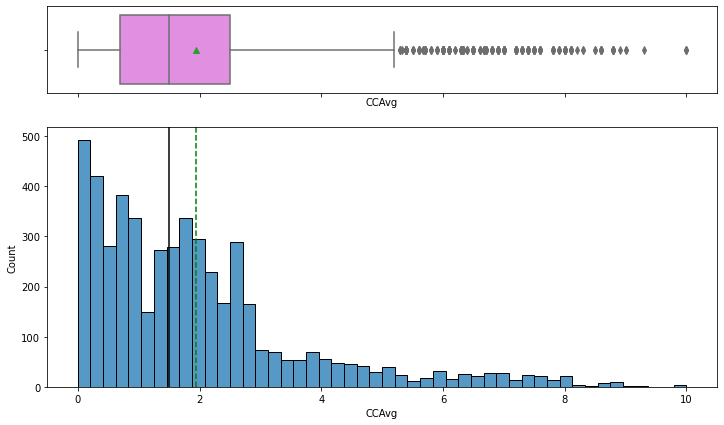

In [26]:
histogram_boxplot(df, 'CCAvg')

In [27]:
print("Column: CCAvg has skewness ",df['CCAvg'].skew())

Column: CCAvg has skewness  1.5984433366678663


That's enough skew to be concerning. Let me dive in and check for funny business.

In [28]:
#Identifying the outliers
outlier_ID(df,'CCAvg',4)

The quartiles for CCAvg are the following: Q1 = 0.7, Q3 = 2.5, 4*IQR = 7.2


787     10.0
2101    10.0
2337    10.0
3943     9.3
1339     9.0
3822     9.0
9        8.9
881      8.8
917      8.8
1277     8.8
2447     8.8
2769     8.8
2988     8.8
3312     8.8
3804     8.8
4225     8.8
Name: CCAvg, dtype: float64

In [29]:
CCAvg_out_index = outlier_ID(df,'CCAvg',4).index

The quartiles for CCAvg are the following: Q1 = 0.7, Q3 = 2.5, 4*IQR = 7.2


In [30]:
#Now let's put those outliers in context.
df.loc[CCAvg_out_index]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
787,45.0,15.0,202.0,91380.0,3.0,10.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2101,35.0,5.0,203.0,95032.0,1.0,10.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2337,43.0,16.0,201.0,95054.0,1.0,10.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
3943,61.0,36.0,188.0,91360.0,1.0,9.3,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1339,52.0,25.0,180.0,94545.0,2.0,9.0,2.0,297.0,1.0,0.0,0.0,1.0,0.0
3822,63.0,33.0,178.0,91768.0,4.0,9.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
9,34.0,9.0,180.0,93023.0,1.0,8.9,3.0,0.0,1.0,0.0,0.0,0.0,0.0
881,44.0,19.0,154.0,92116.0,2.0,8.8,1.0,0.0,0.0,0.0,0.0,1.0,0.0
917,45.0,20.0,200.0,90405.0,2.0,8.8,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1277,45.0,20.0,194.0,92110.0,2.0,8.8,1.0,428.0,0.0,0.0,0.0,0.0,0.0


Nothing here jumps out at me as being erroneous. All of these people make huge incomes, it is very plausible for them to spend that much each month on credit card bills.

I don't think anything needs to be removed. I want to transform this variable, but interpreting the coefficient is going to be important. When I make a model I'll check to see if I can leave it untransformed. Until then, I'm going to log10 it for use later in model comparisons.

In [31]:
df['CCavg_log10']=np.log10(df['CCAvg']+1) #I add +1 to keep 0s 0s and to allow the log to happen

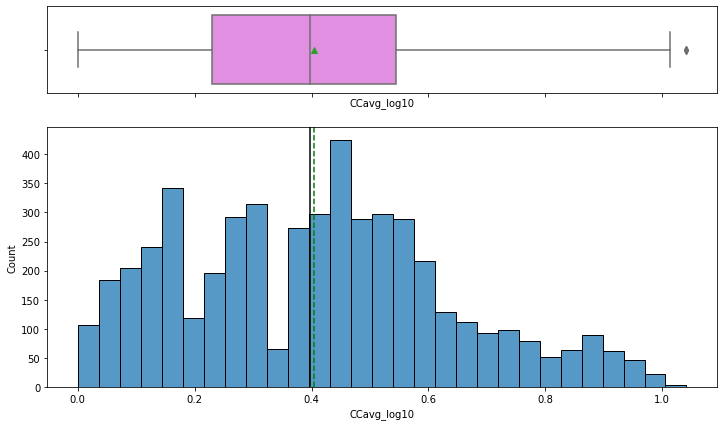

In [32]:
histogram_boxplot(df, 'CCavg_log10')

In [33]:
print("Column: CCAvg_log10 has skewness ",df['CCavg_log10'].skew())

Column: CCAvg_log10 has skewness  0.31922379644464294


The skew is practically eliminated. It looks much more normally distributed now, with only a single outlier. It'll probably help the regression model.

### Observations on Mortgage

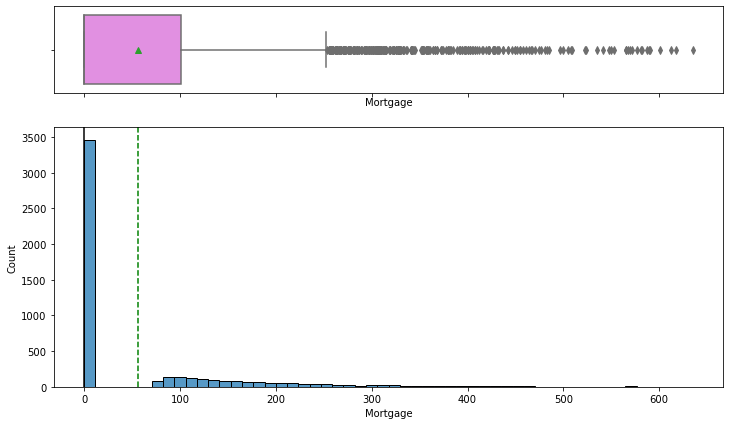

In [34]:
histogram_boxplot(df, 'Mortgage')

In [35]:
print("Column: Mortgage has skewness ",df['Mortgage'].skew())

Column: Mortgage has skewness  2.1040023191079444


Oof, that's a lot of zeroes, and a pretty heavy skew. As much as I'd like to keep this one as-is, I'm going to need to transform it for a regression.

In [36]:
Mortgage_out_index = outlier_ID(df,'Mortgage',4).index

The quartiles for Mortgage are the following: Q1 = 0.0, Q3 = 101.0, 4*IQR = 404.0


In [37]:
#Now let's put those outliers in context.
df.loc[Mortgage_out_index]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10
2934,37.0,13.0,195.0,91763.0,2.0,6.5,1.0,635.0,0.0,0.0,0.0,1.0,0.0,0.875061
303,49.0,25.0,195.0,95605.0,4.0,3.0,1.0,617.0,1.0,0.0,0.0,0.0,0.0,0.602060
4812,29.0,4.0,184.0,92126.0,4.0,2.2,3.0,612.0,1.0,0.0,0.0,1.0,0.0,0.505150
1783,53.0,27.0,192.0,94720.0,1.0,1.7,1.0,601.0,0.0,0.0,0.0,1.0,0.0,0.431364
4842,49.0,23.0,174.0,95449.0,3.0,4.6,2.0,590.0,1.0,0.0,0.0,0.0,0.0,0.748188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,50.0,25.0,160.0,93108.0,4.0,4.3,3.0,410.0,1.0,0.0,0.0,0.0,0.0,0.724276
3357,32.0,6.0,112.0,94111.0,1.0,2.7,2.0,408.0,0.0,1.0,1.0,1.0,1.0,0.568202
2653,30.0,5.0,121.0,94555.0,2.0,3.1,1.0,408.0,0.0,0.0,0.0,1.0,0.0,0.612784
2668,60.0,35.0,113.0,94507.0,1.0,0.9,1.0,406.0,0.0,0.0,0.0,1.0,0.0,0.278754


In [38]:
#That's a lot, I want to see if these make sense.
df.loc[Mortgage_out_index].describe().round()

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10
count,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
mean,45.0,20.0,166.0,93066.0,2.0,4.0,2.0,486.0,1.0,0.0,0.0,1.0,0.0,1.0
std,11.0,11.0,25.0,1820.0,1.0,2.0,1.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0
min,26.0,1.0,112.0,90019.0,1.0,0.0,1.0,405.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,34.0,9.0,148.0,91420.0,1.0,2.0,1.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,44.0,20.0,171.0,93108.0,2.0,4.0,1.0,465.0,1.0,0.0,0.0,1.0,0.0,1.0
75%,54.0,28.0,184.0,94543.0,3.0,6.0,2.0,546.0,1.0,0.0,0.0,1.0,0.0,1.0
max,64.0,40.0,202.0,96008.0,4.0,9.0,3.0,635.0,1.0,1.0,1.0,1.0,1.0,1.0


People with large mortgages tend to be older with large incomes. OK, makes sense. Well, let's log10 it and see if that fixes the problem.

In [39]:
df['Mortgage_log10']=np.log10(df['Mortgage']+1) #I add +1 to keep 0s 0s and to allow the log to happen

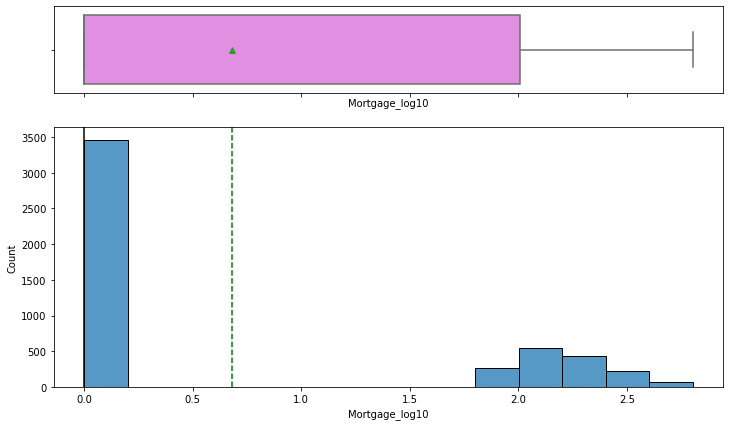

In [40]:
histogram_boxplot(df, 'Mortgage_log10')

Well, at least it took care of the outliers. I'll use this in my regression.

### Observations on Family

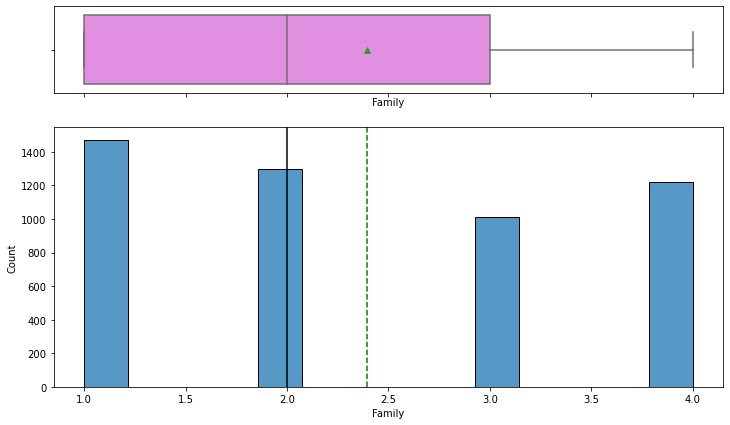

In [41]:
histogram_boxplot(df, 'Family')

In [42]:
print("Column: Family has skewness ",df['Family'].skew())

Column: Family has skewness  0.15522066944367582


Not much spread here, and there is almost no skew at all. I'm leaning towards treating family as a category instead of a continuous column, though. As any parent knows, the amount of life changes caused by increasing numbers of children is not linear. Let me go ahead and do that.

In [43]:
#Making the column an object type so I can add catgories.
df['Family'] = df['Family'].astype('object')
#Turning the numbers into strings so when I dummy it the column names make sense
for i,row in df.iterrows():
    if df.at[i,'Family'] == 1:
        df.at[i,'Family'] = 'One'
    elif df.at[i,'Family'] == 2:
        df.at[i,'Family'] = 'Two'
    elif df.at[i,'Family'] == 3:
        df.at[i,'Family'] = 'Three'
    elif df.at[i,'Family'] == 4:
        df.at[i,'Family'] = 'Four'
#Turn the column into a category
df['Family'] = df['Family'].astype('category')
#Now Dummy it
pd.get_dummies(df,columns=['Family'],drop_first=True)

,Age,Experience,Income,ZIPCode,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10,Mortgage_log10,Family_One,Family_Three,Family_Two
0,25.0,1.0,49.0,91107.0,1.6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.414973,0.000000,0,0,0
1,45.0,19.0,34.0,90089.0,1.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.397940,0.000000,0,1,0
2,39.0,15.0,11.0,94720.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301030,0.000000,1,0,0
3,35.0,9.0,100.0,94112.0,2.7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568202,0.000000,1,0,0
4,35.0,8.0,45.0,91330.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.301030,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29.0,3.0,40.0,92697.0,1.9,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.462398,0.000000,1,0,0
4996,30.0,4.0,15.0,92037.0,0.4,1.0,85.0,0.0,0.0,0.0,1.0,0.0,0.146128,1.934498,0,0,0
4997,63.0,39.0,24.0,93023.0,0.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113943,0.000000,0,0,1
4998,65.0,40.0,49.0,90034.0,0.5,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.176091,0.000000,0,1,0


In [44]:
# function to create labeled barplots for our categorical variables


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Observations on ZIPCode

ZIPCodes are a bit of a headache. We can't use them as-is because there are just way too many categories here, and while the data is hierarchical it isn't linear and the numbers aren't "bigger" or "smaller" than the others. Instead of using ZIPCodes, I'm going to extract a bunch of other potentially useful bits of information from the ZIPCodes and use those instead.

In [45]:
#ZIPCodes need to be an integer so we can look up them.
df['ZIPCode'] = df['ZIPCode'].astype('int64')

In [46]:
#Abbreviating the zipcode search engine.
engine = SearchEngine()

In [47]:
#Getting the state, major city, population density, population size, and county of each zip code
States = []
for i,x in df.iterrows():
    states= engine.by_zipcode(df.at[i,'ZIPCode'])
    States.append(states.state)
Cities = []
for i,x in df.iterrows():
    city= engine.by_zipcode(df.at[i,'ZIPCode'])
    Cities.append(city.major_city)
Density = []
for i,x in df.iterrows():
    dense= engine.by_zipcode(df.at[i,'ZIPCode'])
    Density.append(dense.population_density)
Pop_size = []
for i,x in df.iterrows():
    popu= engine.by_zipcode(df.at[i,'ZIPCode'])
    Pop_size.append(popu.population)
County = []
for i,x in df.iterrows():
    count= engine.by_zipcode(df.at[i,'ZIPCode'])
    County.append(count.county)

In [48]:
#Creating new columns for each of the above pieces of information
df["State"] = States
df['City'] = Cities
df['Pop_Density'] = Density
df['Pop_Size'] = Pop_size
df['County'] = County
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   float64 
 1   Experience          5000 non-null   float64 
 2   Income              5000 non-null   float64 
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   float64 
 7   Mortgage            5000 non-null   float64 
 8   Personal_Loan       5000 non-null   float64 
 9   Securities_Account  5000 non-null   float64 
 10  CD_Account          5000 non-null   float64 
 11  Online              5000 non-null   float64 
 12  CreditCard          5000 non-null   float64 
 13  CCavg_log10         5000 non-null   float64 
 14  Mortgage_log10      5000 non-null   float64 
 15  State               4966 non-null   ob

I'm seeing a lot of missing values. I'll have to deal with those to use this new information.

Let's start with the biggest one and move from there: Pop_Density.

In [49]:
#Get the mean population density for each city.
city_means = pd.DataFrame(df.groupby('City')['Pop_Density'].mean())
city_means

,Pop_Density
City,
Agoura Hills,748.0
Alameda,7593.0
Alamo,1173.0
Albany,13287.0
Alhambra,12101.0
...,...
Westlake Village,610.0
Whittier,2818.0
Woodland Hills,5308.0


Looks good except I bet there are some missing values here.

In [50]:
city_means[city_means['Pop_Density'].isnull()==True]

,Pop_Density
City,
Carpinteria,NaN
San Luis Rey,NaN
Santa Clarita,NaN


That's a small number. I will just manually fix those.

In [51]:
city_means.loc['Carpinteria'] = 5043.4 #from the 2010 census
city_means.loc['San Luis Rey'] = 4216 #from here: https://www.city-data.com/neighborhood/San-Luis-Rey-Oceanside-CA.html
city_means.loc['Santa Clarita'] = 3344.7 #Also from 2010 census.

In [52]:
#Replacing missing values of Pop_Density with the average density for the city.
for i,x in df.iterrows():
    if pd.isnull(df.at[i,'Pop_Density']):
        city = df.at[i,'City']
        try:
            df.at[i,'Pop_Density'] = city_means.loc[city][0]
        except KeyError: #I may get a KeyError None because some of the city means are null.
            pass

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   float64 
 1   Experience          5000 non-null   float64 
 2   Income              5000 non-null   float64 
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   float64 
 7   Mortgage            5000 non-null   float64 
 8   Personal_Loan       5000 non-null   float64 
 9   Securities_Account  5000 non-null   float64 
 10  CD_Account          5000 non-null   float64 
 11  Online              5000 non-null   float64 
 12  CreditCard          5000 non-null   float64 
 13  CCavg_log10         5000 non-null   float64 
 14  Mortgage_log10      5000 non-null   float64 
 15  State               4966 non-null   ob

That didn't get all the missing values in Pop_Density because some values had no city at all.

Before I tackle those, I'm going to do the same treatment to Pop_Size.

In [54]:
#Get the mean population density for each city.
citypop_means = pd.DataFrame(df.groupby('City')['Pop_Size'].mean())
citypop_means

,Pop_Size
City,
Agoura Hills,25488.0
Alameda,60212.0
Alamo,14889.0
Albany,19615.0
Alhambra,52735.0
...,...
Westlake Village,20438.0
Whittier,31974.0
Woodland Hills,39499.0


In [55]:
citypop_means[citypop_means['Pop_Size'].isnull()==True]

,Pop_Size
City,
Carpinteria,NaN
San Luis Rey,NaN
Santa Clarita,NaN


In [56]:
'''
Two of these cities are small and have only one populated zip code. Santa Clarita has multiple.
If I put in the census data for Santa Clarita then each ZIP for this city will get the entire city
population, which would not be correct. I hedged and just gave it the larger zip code's pop.
'''

citypop_means.loc['Carpinteria'] = 13385 #from the census
citypop_means.loc['San Luis Rey'] = 15051 #from here: https://www.city-data.com/neighborhood/San-Luis-Rey-Oceanside-CA.html
citypop_means.loc['Santa Clarita'] = 42326 #from here: https://www.zip-codes.com/zip-code/91350/zip-code-91350.asp

In [57]:
#Replacing missing values of Pop_Density with the average density for the city.
for i,x in df.iterrows():
    if pd.isnull(df.at[i,'Pop_Size']):
        cityp = df.at[i,'City']
        try:
            df.at[i,'Pop_Size'] = citypop_means.loc[cityp][0]
        except KeyError: #I'll get a KeyError None because some of the city means are null.
            pass

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   float64 
 1   Experience          5000 non-null   float64 
 2   Income              5000 non-null   float64 
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   float64 
 7   Mortgage            5000 non-null   float64 
 8   Personal_Loan       5000 non-null   float64 
 9   Securities_Account  5000 non-null   float64 
 10  CD_Account          5000 non-null   float64 
 11  Online              5000 non-null   float64 
 12  CreditCard          5000 non-null   float64 
 13  CCavg_log10         5000 non-null   float64 
 14  Mortgage_log10      5000 non-null   float64 
 15  State               4966 non-null   ob

Now we can tackle those last 44 null values

In [59]:
#Separating out the existent null values to see how many zip codes there are there.
df_null = df[df['Pop_Density'].isnull()==True] #It's the same 44 rows for each, I just picked Pop_Density arbitrarily.
df_null.ZIPCode.value_counts()

92717    22
96651     6
92634     5
93077     1
Name: ZIPCode, dtype: int64

Those are the zip codes that seemingly have no information in the library I used. I'm going to manually look up their information.

However, according to the US Post Office, these are not valid ZIPCodes, and they should know.

I'm going to replace them with as similar of a zip code as possible. According to ZIPCode logic, the closer the number, the closer the geographical area generally speaking. So 92718 should be close to 92717, for example.

In [60]:
df['ZIPCode'] = df['ZIPCode'].astype('string')
df[df['ZIPCode'].str.startswith('9271')]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10,Mortgage_log10,State,City,Pop_Density,Pop_Size,County
106,43.0,17.0,69.0,92717,Four,2.90,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.591065,0.000000,None,None,NaN,NaN,None
172,38.0,13.0,171.0,92717,Two,7.80,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.944483,0.000000,None,None,NaN,NaN,None
184,52.0,26.0,63.0,92717,Two,1.50,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.397940,0.000000,None,None,NaN,NaN,None
321,44.0,20.0,101.0,92717,Three,4.40,2.0,82.0,1.0,0.0,0.0,0.0,0.0,0.732394,1.919078,None,None,NaN,NaN,None
366,50.0,24.0,35.0,92717,One,0.30,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.113943,0.000000,None,None,NaN,NaN,None
476,60.0,34.0,53.0,92717,One,0.80,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.255273,0.000000,None,None,NaN,NaN,None
695,29.0,4.0,115.0,92717,One,1.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.462398,0.000000,None,None,NaN,NaN,None
721,49.0,24.0,39.0,92717,One,1.40,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.380211,0.000000,None,None,NaN,NaN,None
1099,30.0,6.0,52.0,92717,Three,0.70,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.230449,0.000000,None,None,NaN,NaN,None
1189,42.0,17.0,115.0,92717,Two,0.40,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.146128,0.000000,None,None,NaN,NaN,None


The closest I see in ZIPCode for 92717 is 92709, which returned as Irvine, CA.

I'm just going to use the average values of Irvine, CA for 92717. I'll leave the original ZIPCode value, though, as I don't think it will affect much and I am hesitant to remove an original value if I can't prove it to be false.

I'm going to manually look up the missing ZIPs and add in what I find.

In [61]:
for i,x in df.iterrows():
    if pd.isnull(df.at[i,'Pop_Size']):
        if df.at[i,'ZIPCode']=='92717':
            df.at[i,'City'] = 'Irvine'
            df.at[i,'State'] = 'CA'
            df.at[i,'Pop_Density'] = 4606.46875
            df.at[i, 'Pop_Size'] = 25943.53125
            df.at[i,'County'] = 'Orange County'
        elif df.at[i,'ZIPCode'] == '93077':  #I think this is a typo. USPS says this ZIP doesn't exist.
            df.at[i,'ZIPCode'] = '93067' #6 is next to 7 on the keyboard and this IS a zipcode.
            df.at[i,'City'] = 'Summerland'
            df.at[i,'State'] = 'CA'
            df.at[i,'Pop_Density'] = 706.67 #it is a tiny zipcode.
            df.at[i, 'Pop_Size'] = 414
            df.at[i,'County'] = 'Santa Barbara'
        elif df.at[i,'ZIPCode'] == '96651': #This is a military PO Box. It's not a geographic location.
            df.at[i,'City'] = 'FPO'
            df.at[i,'State'] = 'N/A'
            df.at[i,'Pop_Density'] = 1 #I should leave it missing, but then I lose the other info.
            df.at[i,'Pop_Size'] = 1 #All sites say no one lives here, but I assume our customer does.
            df.at[i,'County'] = 'N/A'
        elif df.at[i,'ZIPCode'] == '92634': #Closest real ZIP is 92637, using that info.
            df.at[i,'City'] = 'Laguna Woods'
            df.at[i,'State'] = 'CA'
            df.at[i,'Pop_Density'] = 4631
            df.at[i, 'Pop_Size'] = 16228.0
            df.at[i,'County'] = 'Orange County'

In [62]:
#I'm going to see if there are any non-California states.
df[df['State'] !='CA']

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10,Mortgage_log10,State,City,Pop_Density,Pop_Size,County
630,32.0,7.0,35.0,96651,Three,1.3,1.0,108.0,0.0,0.0,0.0,0.0,1.0,0.361728,2.037426,N/A,FPO,1.0,1.0,N/A
672,51.0,27.0,23.0,96651,One,0.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.079181,0.000000,N/A,FPO,1.0,1.0,N/A
1426,37.0,11.0,60.0,96651,Three,0.5,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.176091,0.000000,N/A,FPO,1.0,1.0,N/A
1653,26.0,1.0,24.0,96651,Two,0.9,3.0,123.0,0.0,0.0,0.0,0.0,1.0,0.278754,2.093422,N/A,FPO,1.0,1.0,N/A
2731,29.0,5.0,28.0,96651,One,0.2,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.079181,0.000000,N/A,FPO,1.0,1.0,N/A
3525,59.0,34.0,13.0,96651,Four,0.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278754,0.000000,N/A,FPO,1.0,1.0,N/A


So the State column only has two values: CA and one I made up. Yeah, that's not going to be useful. It was a lot of work but I'm going to just go ahead and drop that whole column.

In [63]:
#Dropping State because it only has one value.
df.drop(['State'],axis=1,inplace=True)

In [64]:
#I'll change the columns to their proper types.
df['ZIPCode'] = df['ZIPCode'].astype('int64')
df['City'] = df['City'].astype('category')
df['County'] = df['County'].astype('category')
#Now double check all null values are gone
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   float64 
 1   Experience          5000 non-null   float64 
 2   Income              5000 non-null   float64 
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   float64 
 7   Mortgage            5000 non-null   float64 
 8   Personal_Loan       5000 non-null   float64 
 9   Securities_Account  5000 non-null   float64 
 10  CD_Account          5000 non-null   float64 
 11  Online              5000 non-null   float64 
 12  CreditCard          5000 non-null   float64 
 13  CCavg_log10         5000 non-null   float64 
 14  Mortgage_log10      5000 non-null   float64 
 15  City                5000 non-null   ca

Now that I've extracted that information, let's take a look at these new columns

In [65]:
new_cat_columns = ['County',
               'City']
# Printing number of count of each unique value in each column
for column in new_cat_columns:
    print(df[column].value_counts())
    print("-" * 40)

Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda County             500
Orange County              366
San Francisco County       257
San Mateo County           204
Sacramento County          184
Santa Barbara County       154
Yolo County                130
Monterey County            128
Ventura County             114
San Bernardino County      101
Contra Costa County         85
Santa Cruz County           68
Riverside County            56
Marin County                54
Kern County                 54
Solano County               33
San Luis Obispo County      33
Humboldt County             32
Sonoma County               28
Fresno County               26
Placer County               24
Butte County                19
Shasta County               18
El Dorado County            17
Stanislaus County           15
San Benito County           14
San Joaquin County          13
Mendocino County             8
Siskiyou County              7
Tuolumne

In [66]:
new_num_columns = ['Pop_Density',
                   'Pop_Size']
# Printing the descriptive statistics for each new column
for column in new_num_columns:
    print(df[column].describe().round(1))
    print("-" * 40)

count     5000.0
mean      5713.5
std       6354.0
min          1.0
25%       2106.8
50%       3954.0
75%       7161.0
max      50983.0
Name: Pop_Density, dtype: float64
----------------------------------------
count      5000.0
mean      31431.1
std       19246.2
min           0.0
25%       16995.0
50%       31766.0
75%       46369.0
max      105549.0
Name: Pop_Size, dtype: float64
----------------------------------------


### Observations on County

The first thing I note on County is that there are still a ton of counties listed. If I'm going to one-hot this, I have to make an 'Other' category for the log regression. I want to keep the original for the decision tree, though.

In [67]:
#Make a new column just for the log reg.
df['County_logreg'] = df['County']

In [68]:
"""
Function to summarize the Top Company Names and then retain only the ones that constributes to 80% of the cars.
Pareto Principle.
"""

def value_counts_function(data, var, thres, replace):
    
    data_count=data[var].value_counts(normalize=True)*100
    
    print("----------------Value Counts before Treatment----------------------")
    print()

    threshold = thres
    
   

    print(data_count[data_count.values >= threshold])
    
    print()
    print()

    print("% of counties covered using", thres, "% as threshold:",round(data_count[data_count.values >= thres].sum(),2))
    print()
    
    top_var=data_count[data_count.values >= threshold].index.tolist()

    for i, row in data.iterrows():

        if data.at[i,var] not in top_var:

            data.at[i,var]=replace

    print("----------------Value Counts after Treatment----------------------")
    print()
    
    print(data[var].value_counts(normalize=True)*100)
    
    return data

In [69]:
df['County_logreg'] = df['County_logreg'].astype('object')
value_counts_function(df,'County_logreg',3,'Other')

----------------Value Counts before Treatment----------------------

Los Angeles County      21.90
San Diego County        11.36
Santa Clara County      11.26
Alameda County          10.00
Orange County            7.32
San Francisco County     5.14
San Mateo County         4.08
Sacramento County        3.68
Santa Barbara County     3.08
Name: County_logreg, dtype: float64


% of counties covered using 3 % as threshold: 77.82

----------------Value Counts after Treatment----------------------

Other                   22.18
Los Angeles County      21.90
San Diego County        11.36
Santa Clara County      11.26
Alameda County          10.00
Orange County            7.32
San Francisco County     5.14
San Mateo County         4.08
Sacramento County        3.68
Santa Barbara County     3.08
Name: County_logreg, dtype: float64


,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg
0,25.0,1.0,49.0,91107,Four,1.6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.414973,0.000000,Pasadena,4008.00000,32940.00000,Los Angeles County,Los Angeles County
1,45.0,19.0,34.0,90089,Three,1.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.397940,0.000000,Los Angeles,11218.00000,3217.00000,Los Angeles County,Los Angeles County
2,39.0,15.0,11.0,94720,One,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301030,0.000000,Berkeley,4761.00000,2964.00000,Alameda County,Alameda County
3,35.0,9.0,100.0,94112,One,2.7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568202,0.000000,San Francisco,23606.00000,79407.00000,San Francisco County,San Francisco County
4,35.0,8.0,45.0,91330,Four,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.301030,0.000000,Northridge,7931.00000,2702.00000,Los Angeles County,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29.0,3.0,40.0,92697,One,1.9,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.462398,0.000000,Irvine,4606.46875,25943.53125,Orange County,Orange County
4996,30.0,4.0,15.0,92037,Four,0.4,1.0,85.0,0.0,0.0,0.0,1.0,0.0,0.146128,1.934498,La Jolla,3577.00000,46781.00000,San Diego County,San Diego County
4997,63.0,39.0,24.0,93023,Two,0.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113943,0.000000,Ojai,76.00000,20589.00000,Ventura County,Other
4998,65.0,40.0,49.0,90034,Three,0.5,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.176091,0.000000,Los Angeles,18621.00000,57964.00000,Los Angeles County,Los Angeles County


I don't like having the largest county category be "other" but if I don't do that the number of categories for county is just too large. I want to keep it to 10 or fewer.

In [70]:
#Change it back to category now that I've set the categories.
df['County_logreg'] = df['County_logreg'].astype('category')

### Observations on City

We may have to do the same thing to city as we did to county. It may end up being unusable. Let's see if any one city dominates the dataset.

In [71]:
#Get percent share of values per city
df["City"].value_counts(normalize=True)*100

Los Angeles      7.50
San Diego        5.38
San Francisco    5.14
Berkeley         4.82
Sacramento       2.96
                 ... 
Ladera Ranch     0.02
Tahoe City       0.02
Stinson Beach    0.02
Sierra Madre     0.02
Sausalito        0.02
Name: City, Length: 247, dtype: float64

The city with the highest proportion of the sample is only 7%? This isn't going to be workable for a log regression. I'll keep city for use in a decision tree, but I'm not going to be able to one-hot this.

### Observations on Pop_Density

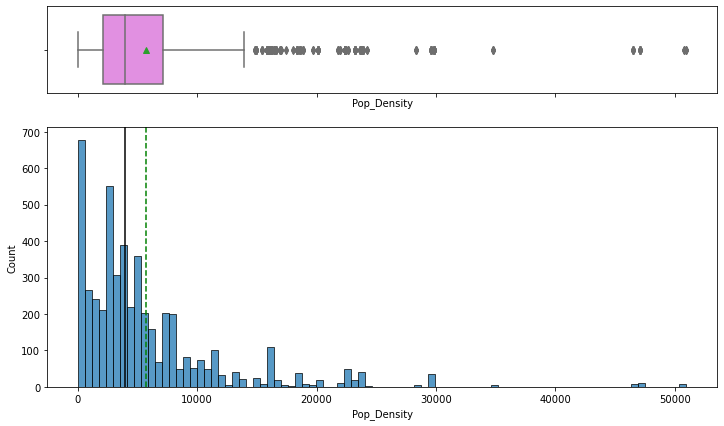

In [72]:
histogram_boxplot(df, 'Pop_Density')

In [73]:
print("Column: Pop_Density has skewness ",df['Pop_Density'].skew())

Column: Pop_Density has skewness  2.8643091165205483


In [74]:
Density_out_index = outlier_ID(df,'Pop_Density',4).index

The quartiles for Pop_Density are the following: Q1 = 2106.75, Q3 = 7161.0, 4*IQR = 20217.0


In [75]:
#Now let's put those outliers in context.
df.loc[Density_out_index]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg
3096,43.0,18.0,179.0,94108,Three,1.2,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.342423,0.000000,San Francisco,50983.0,13768.0,San Francisco County,San Francisco County
4465,39.0,15.0,54.0,94108,Four,2.2,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.505150,0.000000,San Francisco,50983.0,13768.0,San Francisco County,San Francisco County
2077,34.0,9.0,160.0,94108,Four,8.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.954243,0.000000,San Francisco,50983.0,13768.0,San Francisco County,San Francisco County
4063,47.0,21.0,24.0,94108,Two,0.1,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041393,0.000000,San Francisco,50983.0,13768.0,San Francisco County,San Francisco County
120,54.0,29.0,12.0,90057,Two,0.2,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.079181,0.000000,Los Angeles,50810.0,44998.0,Los Angeles County,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,61.0,36.0,40.0,90029,Three,0.5,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.176091,0.000000,Los Angeles,28359.0,38617.0,Los Angeles County,Los Angeles County
3013,45.0,21.0,183.0,90029,Two,1.4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.380211,0.000000,Los Angeles,28359.0,38617.0,Los Angeles County,Los Angeles County
1222,61.0,37.0,20.0,90011,Three,0.4,2.0,94.0,0.0,0.0,0.0,0.0,0.0,0.146128,1.977724,Los Angeles,24240.0,103892.0,Los Angeles County,Los Angeles County
1685,40.0,16.0,89.0,90011,Four,0.8,1.0,155.0,0.0,0.0,0.0,1.0,0.0,0.255273,2.193125,Los Angeles,24240.0,103892.0,Los Angeles County,Los Angeles County


It's very skewed and has some huge outliers. However, these outliers make sense as they are in very dense big cities. I manually checked some of these zips and they really are that dense. I think it best to transform it.

In [76]:
df['PopDense_sqrt']=np.sqrt(df['Pop_Density']) #I use sqrt because a log was too strong and made it left skewed.

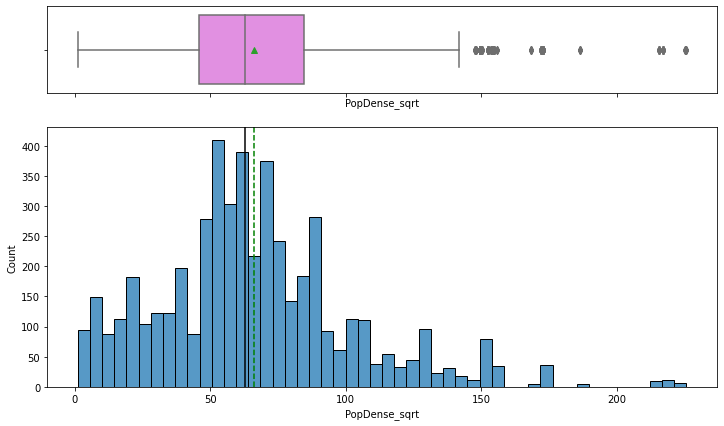

In [77]:
histogram_boxplot(df, 'PopDense_sqrt')

In [78]:
print("Column: Pop_Density sqrt has skewness ",df['PopDense_sqrt'].skew())

Column: Pop_Density sqrt has skewness  0.8556875141461582


### Observations on Pop_Size

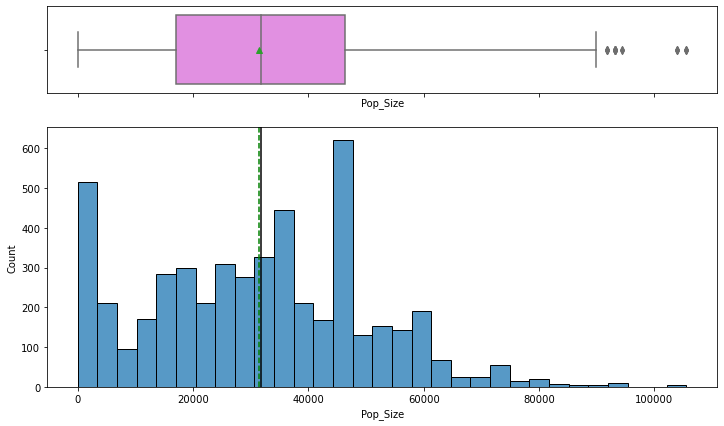

In [79]:
histogram_boxplot(df, 'Pop_Size')

In [80]:
print("Column: Pop_Size has skewness ",df['Pop_Size'].skew())

Column: Pop_Size has skewness  0.270834755729293


Not a bad skew at all. Let's look at those outliers to make sure there is no funny business.

In [81]:
outlier_ID(df,'Pop_Size',2) #The IQR multplier had to be pretty small to catch anything.

The quartiles for Pop_Size are the following: Q1 = 16995.0, Q3 = 46369.0, 2*IQR = 58748.0


1781    105549.0
994     105549.0
2802    105549.0
1222    103892.0
2922    103892.0
1685    103892.0
2685     94396.0
3476     94396.0
4490     93193.0
4367     93193.0
170      93193.0
1708     93193.0
1423     93193.0
1320     93193.0
956      93193.0
769      93193.0
4723     93193.0
1865     91725.0
2243     91725.0
466      91725.0
4236     91725.0
Name: Pop_Size, dtype: float64

In [82]:
#Let's look at the larger outlier.
df.iloc[1781]

Age                                 52.0
Experience                          26.0
Income                              19.0
ZIPCode                            90650
Family                               Two
CCAvg                                0.7
Education                            2.0
Mortgage                             0.0
Personal_Loan                        0.0
Securities_Account                   0.0
CD_Account                           0.0
Online                               0.0
CreditCard                           1.0
CCavg_log10                     0.230449
Mortgage_log10                       0.0
City                             Norwalk
Pop_Density                      10761.0
Pop_Size                        105549.0
County                Los Angeles County
County_logreg         Los Angeles County
PopDense_sqrt                  103.73524
Name: 1781, dtype: object

I manually checked that zip. It really is that big.

Our descriptive statistics also told us that some ZIPs had 0 pop.

In [83]:
#Calling all pops with 0 population
df[df['Pop_Size']==0]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,...,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg,PopDense_sqrt
958,55.0,29.0,78.0,90747,Four,2.6,3.0,0.0,0.0,0.0,...,0.0,1.0,0.556303,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
1858,35.0,11.0,65.0,90747,Three,2.8,1.0,240.0,0.0,0.0,...,1.0,0.0,0.579784,2.382017,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
1991,46.0,22.0,30.0,90747,Three,0.5,1.0,0.0,0.0,0.0,...,0.0,0.0,0.176091,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
2156,35.0,11.0,93.0,90747,Two,2.7,1.0,0.0,0.0,0.0,...,1.0,1.0,0.568202,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
3003,52.0,28.0,44.0,90747,Three,1.9,2.0,0.0,0.0,0.0,...,0.0,1.0,0.462398,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
3287,39.0,13.0,32.0,90747,Two,0.8,3.0,0.0,0.0,0.0,...,1.0,0.0,0.255273,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
3447,54.0,29.0,25.0,90747,Four,0.1,3.0,109.0,0.0,0.0,...,0.0,0.0,0.041393,2.041393,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179
4779,39.0,14.0,20.0,90747,One,0.6,3.0,0.0,0.0,0.0,...,1.0,0.0,0.204120,0.000000,Carson,6897.0,0.0,Los Angeles County,Los Angeles County,83.048179


It has population density but no population? That's a library error. I'll fix it manually.

Looking up Carson, CA, it has four zipcodes assigned to it, two of which have populations. I'll just average them and sub them in. I think if someone has a P.O. box in Carson they probably live there, and the geographic features of where they live is what we're trying to gleam here.

61,194 in one and 26,024 in the other means an average of 43,609.

In [84]:
#Imputing the new value
for i,x in df.iterrows():
    if df.at[i,'ZIPCode'] == 90747:
        df.at[i,'Pop_Size'] = 43609
df[df['ZIPCode']==90747]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,...,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg,PopDense_sqrt
958,55.0,29.0,78.0,90747,Four,2.6,3.0,0.0,0.0,0.0,...,0.0,1.0,0.556303,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
1858,35.0,11.0,65.0,90747,Three,2.8,1.0,240.0,0.0,0.0,...,1.0,0.0,0.579784,2.382017,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
1991,46.0,22.0,30.0,90747,Three,0.5,1.0,0.0,0.0,0.0,...,0.0,0.0,0.176091,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
2156,35.0,11.0,93.0,90747,Two,2.7,1.0,0.0,0.0,0.0,...,1.0,1.0,0.568202,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
3003,52.0,28.0,44.0,90747,Three,1.9,2.0,0.0,0.0,0.0,...,0.0,1.0,0.462398,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
3287,39.0,13.0,32.0,90747,Two,0.8,3.0,0.0,0.0,0.0,...,1.0,0.0,0.255273,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
3447,54.0,29.0,25.0,90747,Four,0.1,3.0,109.0,0.0,0.0,...,0.0,0.0,0.041393,2.041393,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179
4779,39.0,14.0,20.0,90747,One,0.6,3.0,0.0,0.0,0.0,...,1.0,0.0,0.204120,0.000000,Carson,6897.0,43609.0,Los Angeles County,Los Angeles County,83.048179


There, now let's look at the figure again.

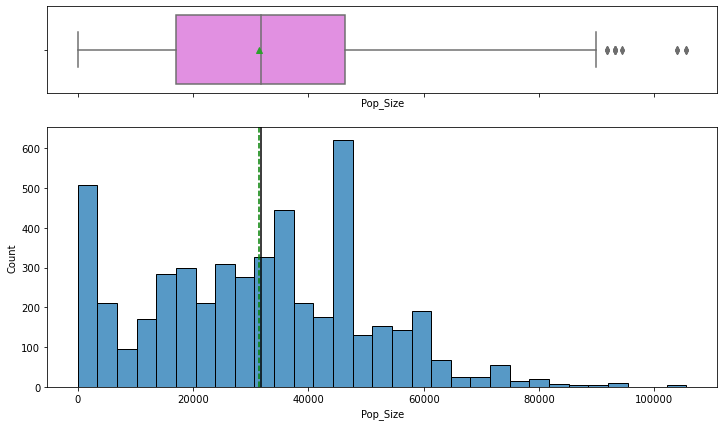

In [85]:
histogram_boxplot(df, 'Pop_Size')

In [86]:
df['Pop_Size'].describe().round(1)

count      5000.0
mean      31500.8
std       19211.2
min           1.0
25%       16995.0
50%       31806.0
75%       46369.0
max      105549.0
Name: Pop_Size, dtype: float64

The 1s are the FPO I added. There are also several zipcodes with very small populations but it is possible to have that in rural areas. I'll manually look at a few anyway just to be sure.

In [87]:
df[df['Pop_Size']<10]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,...,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg,PopDense_sqrt
7,50.0,24.0,22.0,93943,One,0.3,3.0,0.0,0.0,0.0,...,0.0,1.0,0.113943,0.000000,Monterey,35.0,6.0,Monterey County,Other,5.916080
21,57.0,27.0,63.0,90095,Three,2.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.477121,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
173,58.0,34.0,42.0,90095,Four,1.5,1.0,0.0,0.0,0.0,...,1.0,1.0,0.397940,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
243,65.0,39.0,170.0,90095,Three,7.9,3.0,99.0,1.0,0.0,...,1.0,0.0,0.949390,2.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
273,41.0,16.0,65.0,90095,Three,0.5,3.0,0.0,0.0,0.0,...,1.0,0.0,0.176091,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,40.0,15.0,43.0,90095,Four,1.7,1.0,98.0,0.0,0.0,...,0.0,0.0,0.431364,1.995635,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
4913,30.0,4.0,110.0,93943,One,2.9,3.0,0.0,0.0,0.0,...,1.0,0.0,0.591065,0.000000,Monterey,35.0,6.0,Monterey County,Other,5.916080
4930,63.0,38.0,110.0,90095,Three,1.8,2.0,109.0,0.0,0.0,...,1.0,0.0,0.447158,2.041393,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
4958,50.0,26.0,19.0,90095,One,0.9,3.0,0.0,0.0,0.0,...,0.0,0.0,0.278754,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427


I looked up 90095 and discovered in 2010 it only had 3 residents. Currently, it is expected to have 0.

In [88]:
#The census says only 3 people live there. How many of our customers live there?
df[df['ZIPCode']==90095]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,...,Online,CreditCard,CCavg_log10,Mortgage_log10,City,Pop_Density,Pop_Size,County,County_logreg,PopDense_sqrt
21,57.0,27.0,63.0,90095,Three,2.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.477121,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
173,58.0,34.0,42.0,90095,Four,1.5,1.0,0.0,0.0,0.0,...,1.0,1.0,0.397940,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
243,65.0,39.0,170.0,90095,Three,7.9,3.0,99.0,1.0,0.0,...,1.0,0.0,0.949390,2.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
273,41.0,16.0,65.0,90095,Three,0.5,3.0,0.0,0.0,0.0,...,1.0,0.0,0.176091,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
293,45.0,19.0,93.0,90095,Four,2.6,3.0,0.0,0.0,0.0,...,0.0,0.0,0.556303,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665,40.0,16.0,65.0,90095,Two,3.2,1.0,0.0,0.0,0.0,...,1.0,0.0,0.623249,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
4770,35.0,5.0,93.0,90095,Four,1.8,3.0,0.0,0.0,0.0,...,0.0,1.0,0.447158,0.000000,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
4879,40.0,15.0,43.0,90095,Four,1.7,1.0,98.0,0.0,0.0,...,0.0,0.0,0.431364,1.995635,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427
4930,63.0,38.0,110.0,90095,Three,1.8,2.0,109.0,0.0,0.0,...,1.0,0.0,0.447158,2.041393,Los Angeles,8.0,3.0,Los Angeles County,Los Angeles County,2.828427


71 families live in a zip code where zip-codes.com says there are 3 people total. Hmm.

Other zip-code demographic sites say this is not a valid zipcode at all.

The USPS says it does exist, though.

At this point I'm finding so many errors in the ZIPCode data that I suspect the entire column to be corrupted by bad information. I'm just going to leave it how it is and test it on the models. I don't want to spend a lot of time on this when it probably isn't even an important factor.

It is what it is, it's fairly normally distributed, it has little skew, and I don't need to transform the outliers. Time to move on.

### Observations on Education

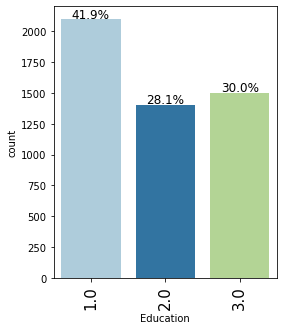

In [89]:
labeled_barplot(df, 'Education', perc=True)

Of the sample, almost half only have an undergraduate degree, then about the same number have a masters or advanced/professional degree.

Oddly, nobody in the sample has no degree at all. This is important, as many people with only highschool degrees or associates degrees end up with good credit, high paying jobs, and active bank accounts.

### Observations on Securities_Account

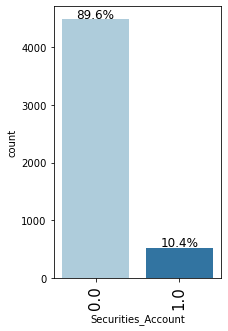

In [90]:
labeled_barplot(df, 'Securities_Account', perc=True)

About 90% of the sample did not have a securities account with the bank last campaign. This is assuming that is what 1 means, as this was not defined in the dictionary.

### Observations on CD_Account

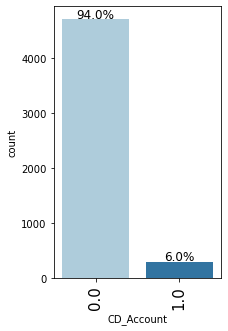

In [91]:
labeled_barplot(df, 'CD_Account', perc=True)

94% of the sample did not have a CD_Account with the bank last campaign.

### Observations on Online

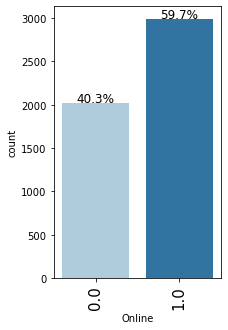

In [92]:
labeled_barplot(df, 'Online', perc=True)

A Noteworthy part of this variable is that the definitions don't tell us what these numbers mean. I'm going to assume 1 means "uses internet banking facilities" since that is the pattern used elsewhere.

Only 59.7% use online banking? That's shockingly low to me. I wonder how it interacts with Age.

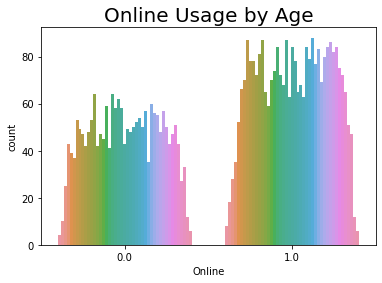

In [93]:
#Check out how age is distributed when we split for online.
sns.countplot(df["Online"],hue=df["Age"])
plt.title("Online Usage by Age", fontsize=20)
plt.legend('',frameon=False)

Hm, the ages look about the same in both. I find that odd but it is how it is.

### Observations on CreditCard

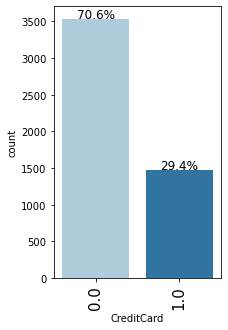

In [94]:
labeled_barplot(df, 'CreditCard', perc=True)

Almost a third of the sample uses a credit card issued by another bank. That also strikes me as extremely odd, considering most people I know have several credit cards all from different places. I would cast a lot of doubt on this data and would like to know how it was collected.

The average number of credit cards held by an American Consumer is 3 (https://www.elitepersonalfinance.com/average-number-credit-cards-per-person/). We're expected to believe that all three of those are from our bank for 70% of our customers, or that the average customer for our bank is so radically different from the average person? It's a tough pill to swallow. It's so impossible to believe that I'm tempted to drop this entire column.

### Observations on Personal_Loan

I saved the most important variable for last. I really want to see how this interacts with the other variables.

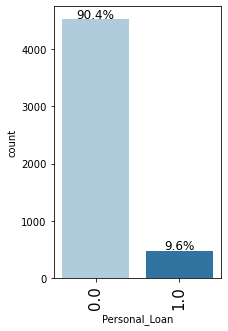

In [95]:
labeled_barplot(df, 'Personal_Loan', perc=True)

The sample is extremely lopsided. We'll have to account for this when building our models. Now, I want to visually inspect how our dependent variable interacts with the other variables.

In [96]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [97]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

#### Personal_Loan vs Age

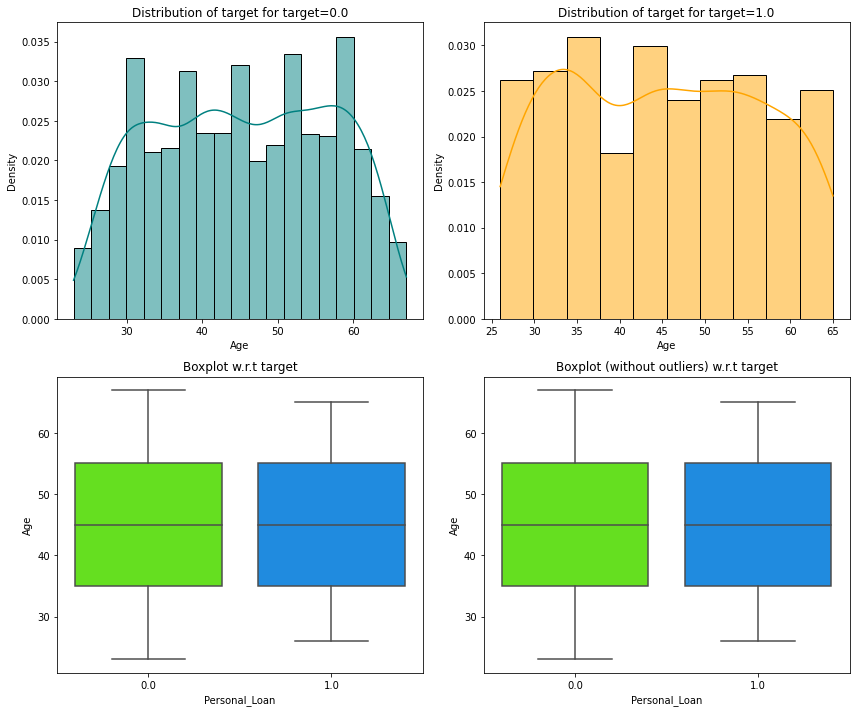

In [98]:
distribution_plot_wrt_target(df, "Age", "Personal_Loan")

About the same for both groups.

#### Personal_Loan vs. Experience

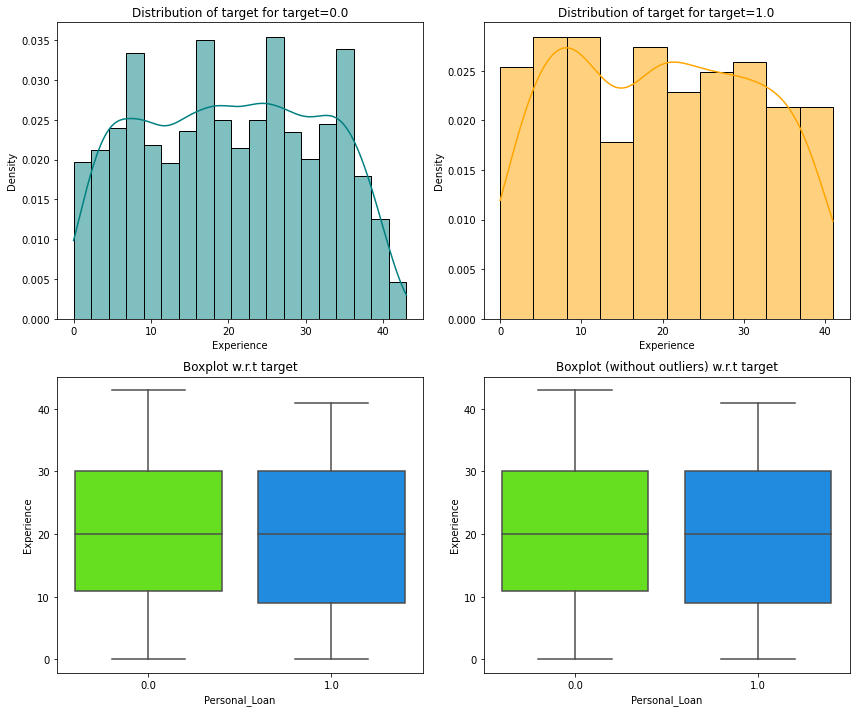

In [99]:
distribution_plot_wrt_target(df, "Experience", "Personal_Loan")

The distribution is slightly flatter for those who bought the personal loan, and the highest experience values are for those who did not. Overall, I think if we did a means test we'd find there is no significant difference here.

#### Personal_Loan vs. Income

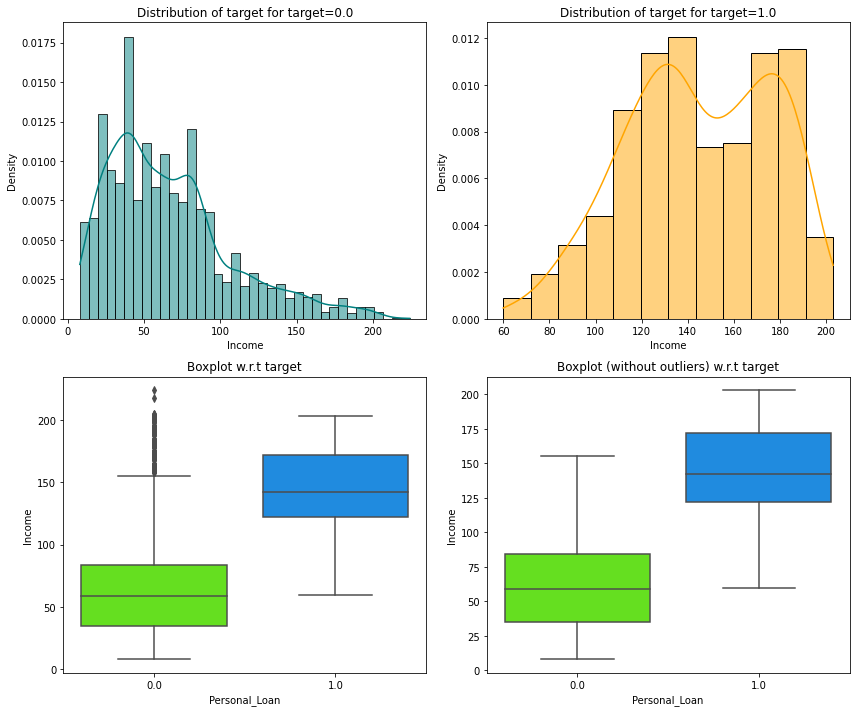

In [100]:
distribution_plot_wrt_target(df, "Income", "Personal_Loan")

For those who didn't purchase a loan last campaign, their income is skewed to the right. The opposite is true for those who did.

Clearly there is a relationship between income and those who took the personal loan. Somewhat counterintuitively, people with higher incomes definitely purchased the loan much more often last campaign, and to such an extreme degree that the lower whisker of income for those who bought the oan is about equal to the mean income of those who didn't.

#### Personal_Loan vs. CCAvg

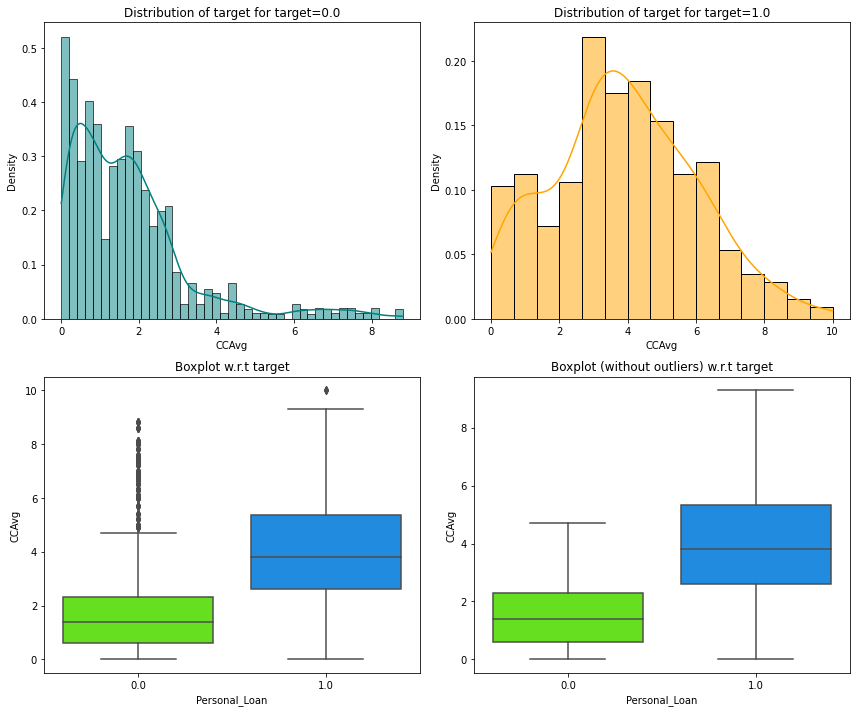

In [101]:
distribution_plot_wrt_target(df, "CCAvg", "Personal_Loan")

CCAvg was already fairly skewed, and we continue to see that for those who did not purchase a loan. However, that skew largely vanishes for those who did buy a loan. 


The mean CCAvg of those who purchased a loan is substantially higher than the mean of those who did not, though the distribution is a bit flatter. The range is about the same.

It seems, then, that those who spend more on their credit card were more responsive to last season's ad campaign.

#### Personal_Loan vs. Mortgage

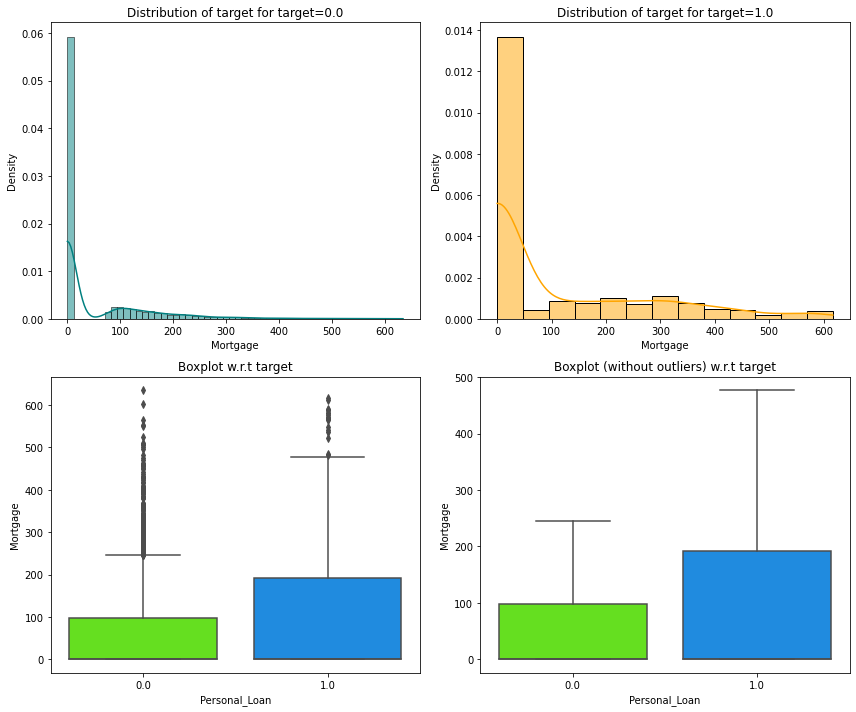

In [102]:
distribution_plot_wrt_target(df, "Mortgage", "Personal_Loan")

Both parts of the sample here are extremely right skewed due to the large number of zeroes. They look very similar. I'll double check with the log10.

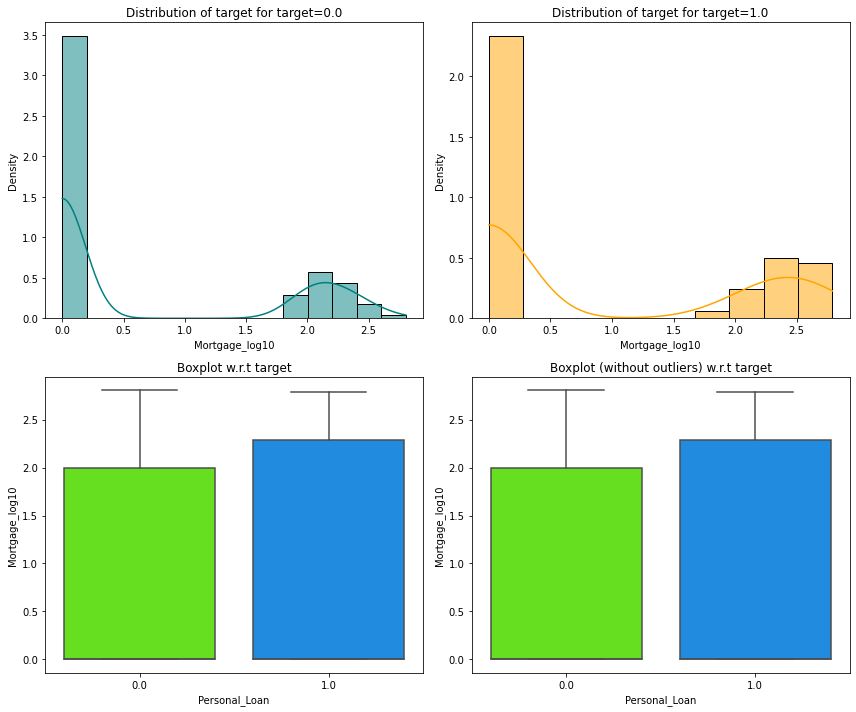

In [103]:
distribution_plot_wrt_target(df, "Mortgage_log10", "Personal_Loan")

Even after the log transformation there is almost no difference between the two groups. If we discount the large number of zeroes, we see that those willing to buy the personal loan are slightly more likely to have a higher mortgage. I'm curious what proportion have a mortgage at all as well.

In [104]:
#Just getting a percent by dividing the part by the whole.
perc_noloan_nomortgage = len(df[(df['Personal_Loan']==0) 
                                & (df['Mortgage']==0)])/len(df[(df['Personal_Loan']==0)])
print(f'{perc_noloan_nomortgage*100} percent who didn\'t buy a loan also didn\'t have a mortgage')

69.69026548672566 percent who didn't buy a loan also didn't have a mortgage


In [105]:
#Just getting a percent by dividing the part by the whole.
perc_loan_nomortgage = len(df[(df['Personal_Loan']==1) 
                              & (df['Mortgage']==0)])/len(df[(df['Personal_Loan']==1)])
print(f'{perc_loan_nomortgage*100} percent who did buy a loan didn\'t have a mortgage')

65.0 percent who did buy a loan didn't have a mortgage


That's about the same proportion. Likely no significant difference.

#### Personal_Loan vs. Pop_Density

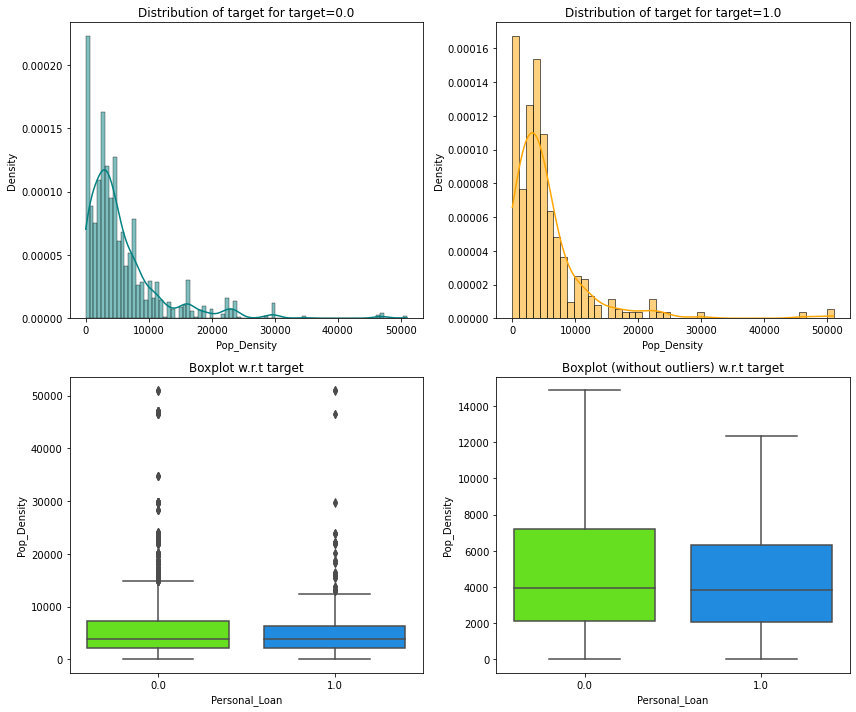

In [106]:
distribution_plot_wrt_target(df, "Pop_Density", "Personal_Loan")

Those two distributions look about the same regardless of whether they bought a loan or not. Of course there are tons of outliers, as this is the untreated sample. There is a slightly flatter spread for those who didn't take the loan, but I doubt it is significant.

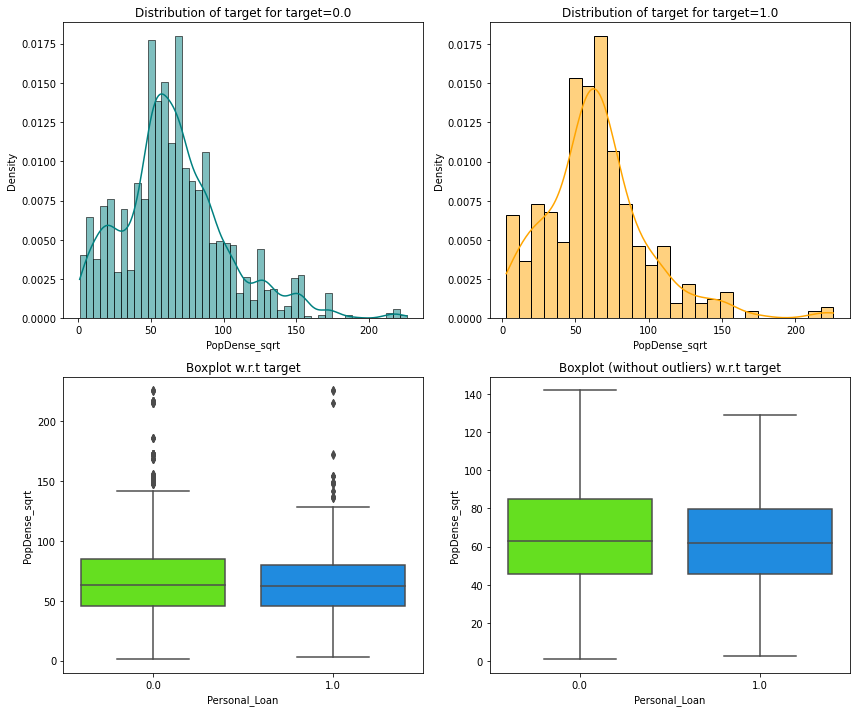

In [107]:
distribution_plot_wrt_target(df, "PopDense_sqrt", "Personal_Loan")

It's the same for the sqrt version, unsurprisingly. Not much to see here. I doubt this will have much of an impact.

#### Personal_Loan vs. Pop_Size

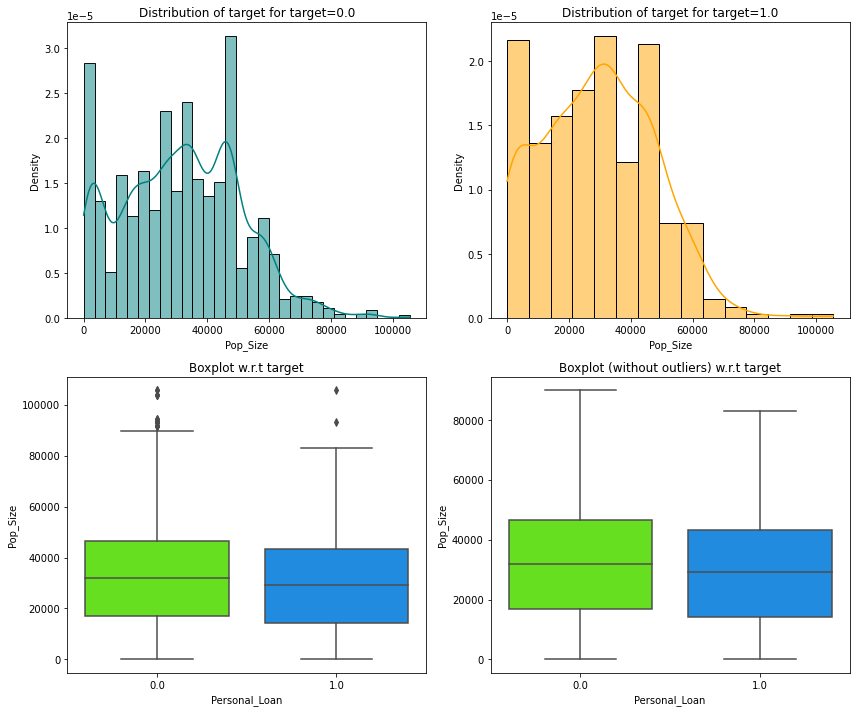

In [108]:
distribution_plot_wrt_target(df, "Pop_Size", "Personal_Loan")

Whether or not they lived in a high population area does not seem to make a difference in whether they bought a loan last campaign or not. The mean for those who did buy the loan is slightly lower, but I suspect that would be due to random chance.

#### Personal_Loan vs. County

There are so many categories for county that the visualization is going to be messy. But, I think we can still learn some from it.

Personal_Loan            0.0  1.0   All
County                                 
All                     4520  480  5000
Los Angeles County       984  111  1095
Santa Clara County       492   71   563
San Diego County         509   59   568
Alameda County           456   44   500
Orange County            333   33   366
San Francisco County     238   19   257
Monterey County          113   15   128
Sacramento County        169   15   184
Contra Costa County       73   12    85
San Mateo County         192   12   204
Ventura County           103   11   114
Santa Barbara County     143   11   154
Santa Cruz County         60    8    68
Yolo County              122    8   130
Kern County               47    7    54
Sonoma County             22    6    28
Marin County              48    6    54
Riverside County          50    6    56
San Luis Obispo County    28    5    33
Solano County             30    3    33
San Bernardino County     98    3   101
Shasta County             15    3    18


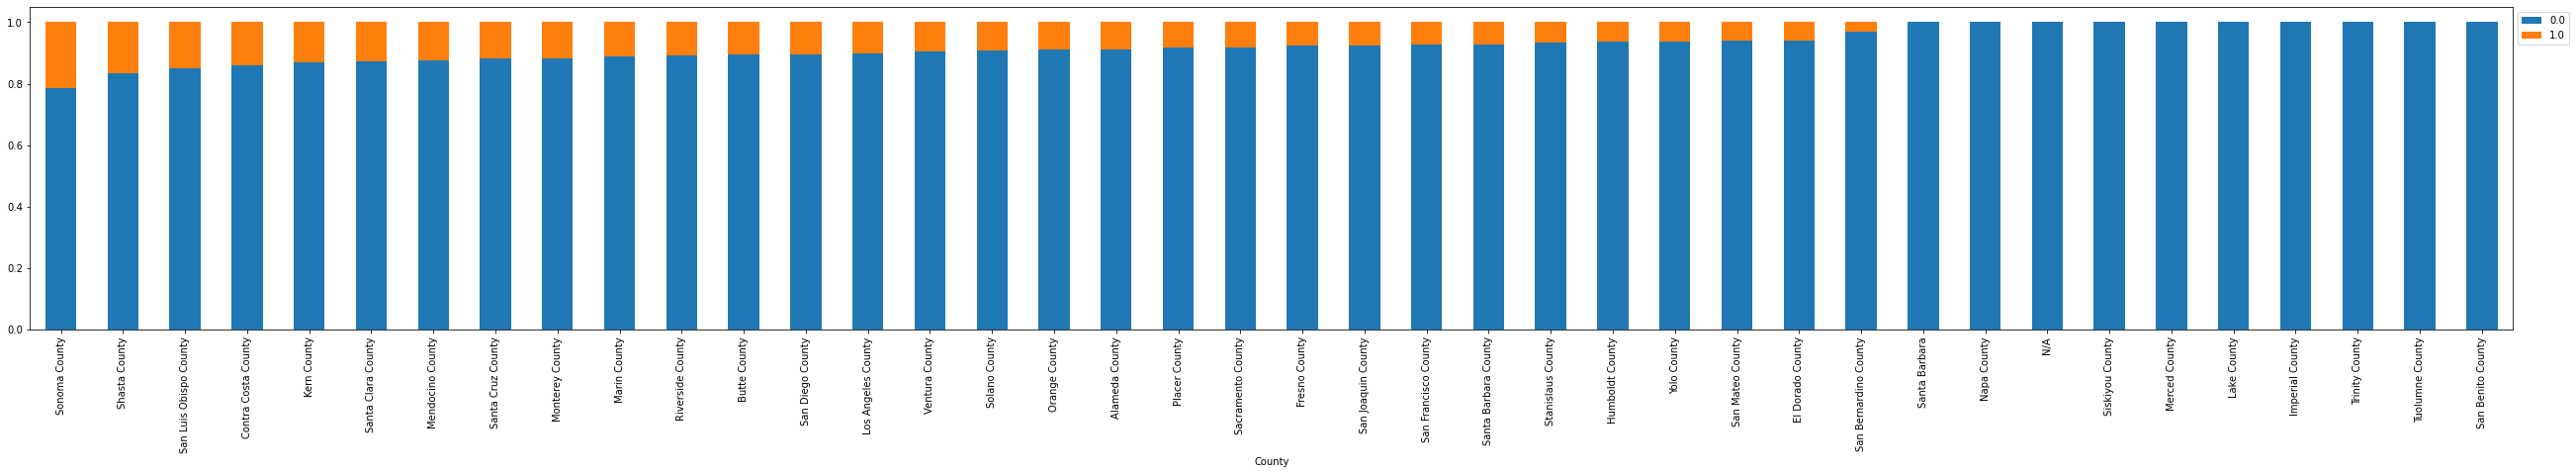

In [109]:
stacked_barplot(df, "County", "Personal_Loan")

There are definitely some counties that had more people buy personal loans than others, with 10 counties having none at all. This variable won't have a huge impact, but it should factor in to the predictions.

Unfortunately, the two most proportional counties to have loan buyers are nowhere near each other. I am not sure what trend there is beyond "Is in this county."

Personal_Loan          0.0  1.0   All
County_logreg                        
All                   4520  480  5000
Los Angeles County     984  111  1095
Other                 1004  105  1109
Santa Clara County     492   71   563
San Diego County       509   59   568
Alameda County         456   44   500
Orange County          333   33   366
San Francisco County   238   19   257
Sacramento County      169   15   184
San Mateo County       192   12   204
Santa Barbara County   143   11   154
------------------------------------------------------------------------------------------------------------------------


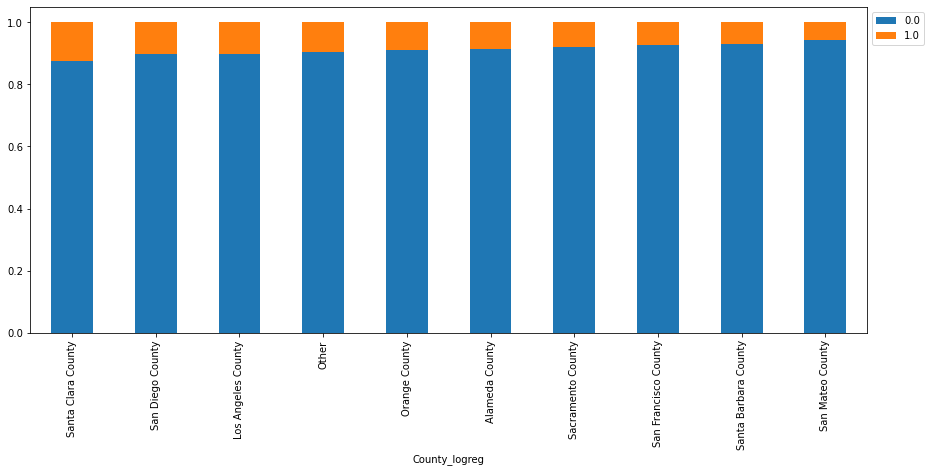

In [110]:
#May as well look at the logreg version. It's more readable.
stacked_barplot(df, "County_logreg", "Personal_Loan")

Again there does seem to be a small trend. What is driving the trend is currently unknown.

#### Personal_Loan vs. City

If you thought county was messy, wait for city.

Personal_Loan   0.0  1.0   All
City                          
All            4520  480  5000
Los Angeles     337   38   375
Berkeley        214   27   241
San Diego       248   21   269
San Francisco   238   19   257
...             ...  ...   ...
North Hills       3    0     3
Bodega Bay        6    0     6
National City     7    0     7
Napa              3    0     3
Agoura Hills      6    0     6

[248 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


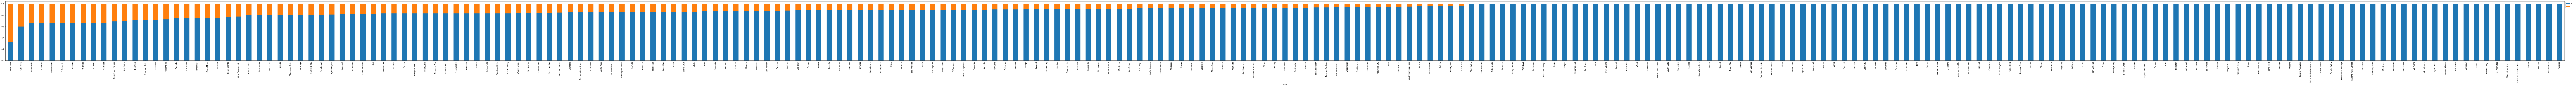

In [111]:
stacked_barplot(df, "City", "Personal_Loan")

If you zoom in on that, this is much more obvious of a trend than even county, with many many cities having no loan purchasers at all.

Also, wowsers, Bella Vista has a massive proportion of purchasers in it.

I'd love to have this in the log reg, but I think there are too many categories. It will do better in a decision tree.

#### Personal_Loan vs. Family

Personal_Loan   0.0  1.0   All
Family                        
All            4520  480  5000
Four           1088  134  1222
Three           877  133  1010
One            1365  107  1472
Two            1190  106  1296
------------------------------------------------------------------------------------------------------------------------


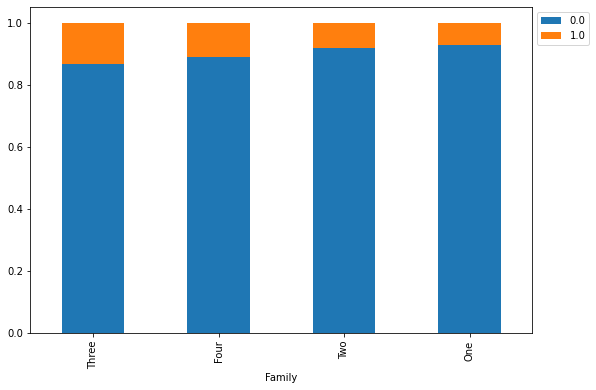

In [112]:
stacked_barplot(df, "Family", "Personal_Loan")

As we can see from the above graph, people who bought loans seem to make up a slightly larger concentration of those with larger families. From this I would conclude that the larger the family, the more likely it is that they were to buy a personal loan last campaign.

#### Personal_Loan vs. Education

Personal_Loan   0.0  1.0   All
Education                     
All            4520  480  5000
3.0            1296  205  1501
2.0            1221  182  1403
1.0            2003   93  2096
------------------------------------------------------------------------------------------------------------------------


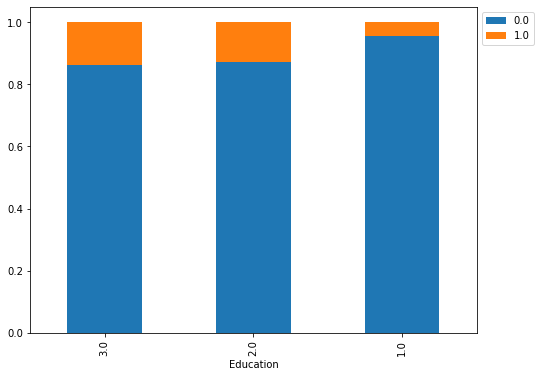

In [113]:
stacked_barplot(df, "Education", "Personal_Loan")

Those with advanced degrees and graduate degrees were more likely than their undergraduate counterparts to buy a loan last campaign. I can conclude that the more education, the more likely they were to buy the loan.

That is assuming "advanced/Professional" means PhD, MBA, and other high level degrees and no associates degrees and professional certificate programs. Without a proper definition of what the Education variable is measuring it is difficult to make conclusions here. I advise in the future that such information be included in the data dictionary.

#### Personal_Loan vs. Securities_Account

Personal_Loan        0.0  1.0   All
Securities_Account                 
All                 4520  480  5000
0.0                 4058  420  4478
1.0                  462   60   522
------------------------------------------------------------------------------------------------------------------------


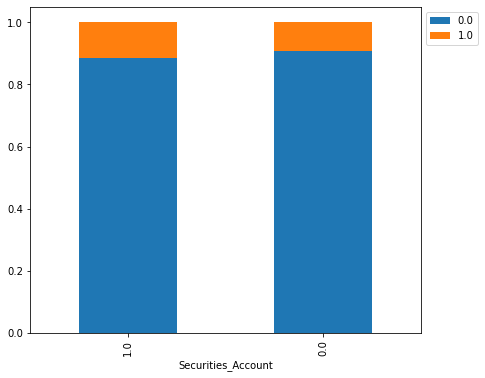

In [114]:
stacked_barplot(df, "Securities_Account", "Personal_Loan")

The difference is so slight here that I suspect it was due to chance, not an actual pattern. Securities accounts didn't seem to influence the decision to buy a loan or not.

#### Personal_Loan vs. CD_Account

Personal_Loan   0.0  1.0   All
CD_Account                    
All            4520  480  5000
0.0            4358  340  4698
1.0             162  140   302
------------------------------------------------------------------------------------------------------------------------


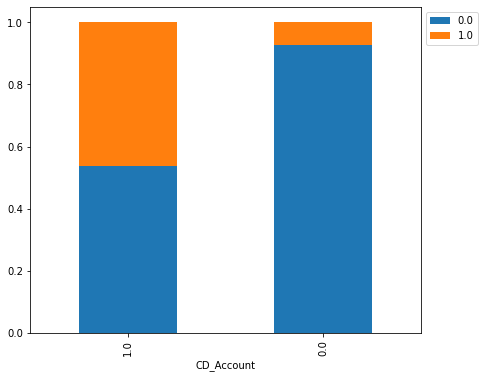

In [115]:
stacked_barplot(df, "CD_Account", "Personal_Loan")

A MUCH larger proportion of those with a CD_Account bought a loan last campaign than didn't. Assuming 1 means they have a CD account with the bank (this is not defined in the dictionary), those who have a CD Account most definitely were more likely to buy a personal loan last campaign.

#### Personal_Loan vs. Online

Personal_Loan   0.0  1.0   All
Online                        
All            4520  480  5000
1.0            2693  291  2984
0.0            1827  189  2016
------------------------------------------------------------------------------------------------------------------------


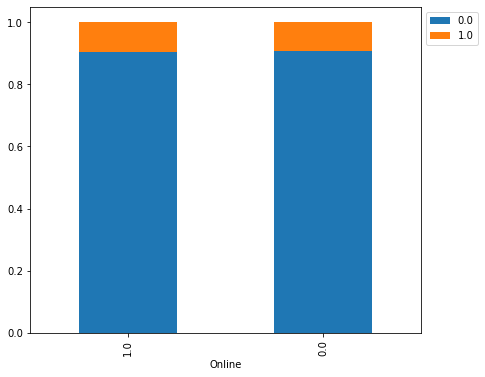

In [116]:
stacked_barplot(df, "Online", "Personal_Loan")

The proportion of those who bought a loan last campaign is about identical whether they use the online banking systems or not.

#### Personal_Loan vs. CreditCard

Personal_Loan   0.0  1.0   All
CreditCard                    
All            4520  480  5000
0.0            3193  337  3530
1.0            1327  143  1470
------------------------------------------------------------------------------------------------------------------------


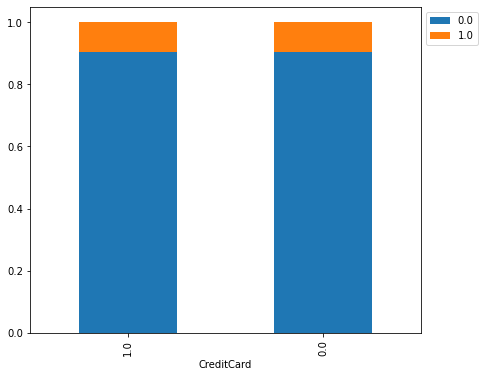

In [117]:
stacked_barplot(df, "CreditCard", "Personal_Loan")

The proportion of those who bought a loan last campaign is about identical whether they use a credit card from another bank or not. However, I'd like to reiterate that this data is suspect and likely inaccurate in its definition. I would not draw any sort of conclusion from this data until we know more about what this data actually means.

#### Personal_Loan and ZIPCode

This is going to be much more difficult to deal with, as ZIPCode has a LOT of categories.

First, let's look at a barplot as before.

Personal_Loan   0.0  1.0   All
ZIPCode                       
All            4520  480  5000
94720           150   19   169
94305           114   13   127
92093            42    9    51
90095            63    8    71
...             ...  ...   ...
92866             8    0     8
92843             3    0     3
92835             3    0     3
92833             4    0     4
90005             5    0     5

[468 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


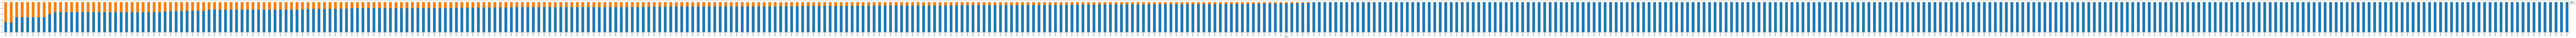

In [118]:
stacked_barplot(df, "ZIPCode", "Personal_Loan")

What we can tell from that eyesore is that almost half of all the zipcodes do not have anyone who bought a personal loan last time.

In [119]:
#Make a list of all zipcodes that have people who bought loans in them.
ZIP_Loans = []
#May as well make an inverse list of that too.
ZIP_Noloan =[]
#Iterrate through the loans and sort out which zips have purchasers.
for i,x in df.iterrows():
    if df.at[i,'Personal_Loan'] == 1:
        ZIP_Loans.append(df.at[i,'ZIPCode'])
    elif df.at[i,'Personal_Loan'] == 0:
        ZIP_Noloan.append(df.at[i,'ZIPCode'])

In [120]:
ZIPs = pd.DataFrame(ZIP_Loans)
ZIPs.value_counts()

94720    19
94305    13
92093     9
94304     8
90095     8
         ..
92709     1
92821     1
92831     1
92834     1
93302     1
Length: 238, dtype: int64

Of the 467 unique ZIPCodes in the database, only 238 actually had people who bought the loan last campaign.

I've already extracted what I can from ZIPCodes. We'll see what feature ends up being most useful when we run the predictions.

## Multivariate Comparisons

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   float64 
 1   Experience          5000 non-null   float64 
 2   Income              5000 non-null   float64 
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   float64 
 7   Mortgage            5000 non-null   float64 
 8   Personal_Loan       5000 non-null   float64 
 9   Securities_Account  5000 non-null   float64 
 10  CD_Account          5000 non-null   float64 
 11  Online              5000 non-null   float64 
 12  CreditCard          5000 non-null   float64 
 13  CCavg_log10         5000 non-null   float64 
 14  Mortgage_log10      5000 non-null   float64 
 15  City                5000 non-null   ca

In [122]:
''' We added some columns so I have to reset the num_cols variable in preparation for the correlations
'''
#Separating out the numerical columns
cat_columns.append('County')
cat_columns.append('County_logreg')
cat_columns.append('City')
num_cols = []
for column in df.columns:
    if column not in cat_columns:
        num_cols.append(column)
num_cols.append('Family') #Adding family in, just in case we want to keep it
num_cols

['Age',
 'Experience',
 'Income',
 'CCAvg',
 'Mortgage',
 'CCavg_log10',
 'Mortgage_log10',
 'Pop_Density',
 'Pop_Size',
 'PopDense_sqrt',
 'Family']

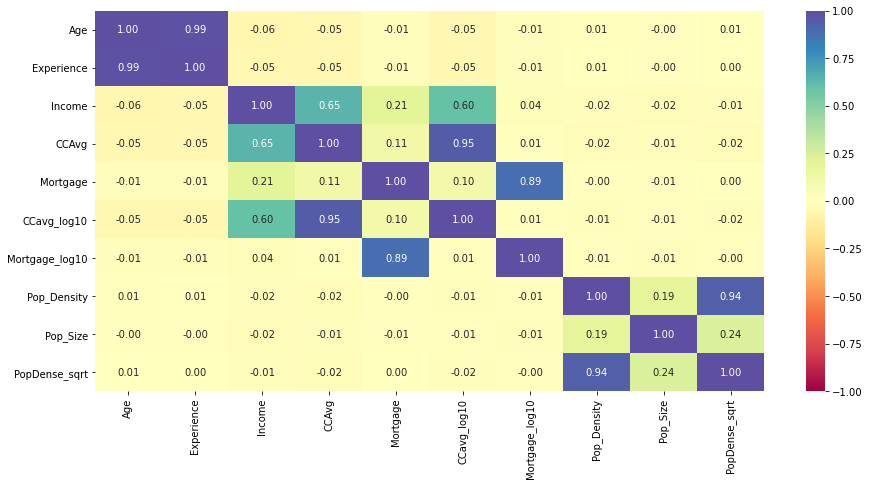

In [123]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

To the surprise of no one, age and experience are highly correlated. So much so that it will violate the multicollinearity assumption of a logistic regression. I'll have to drop one when I run it.

Otherwise, we see that there is a moderate correlation between CCAvg and income.

There are weak correlations between Pop_Size and Pop_Density, which makes sense.

Time to run some models.

# Classification Models

### Model evaluation criterion

### Model can make wrong predictions as:

1. Predicting a customer is not going to buy a personal loan using identical marketing strategies as last campaign but in reality the customer will buy a loan - Loss of sale
2. Predicting a customer is going to buy a personal loan using identical marketing strategies as last campaign but in reality the customer will not - loss of outreach effort


### Which Loss is greater ? 

* Loss of sale will be the greater loss as the bank will be losing a potential customer.
* Reaching out to a customer only to be rejected is, for most marketing, a trivial cost.

### How to reduce this loss i.e need to reduce False Negatives ?

* The bank would want to reduce false negatives to ensure they make as many sales as possible, this can be done by maximizing the Recall. Greater the recall lesser the chances of false negatives.

### What about accuracy?
* All that said, if we can get huge gains in accuracy without sacrificing much recall it is likely best to do so. That will help us more confidentally pinpoint which factors really made customers more responsive to our previous campaign.

## Logistic Regression

In [124]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


In [125]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [126]:
#Then drop the columns that are inappropriate for logreg
df_logreg = df.drop(['Experience','ZIPCode','City','County','CCAvg','Mortgage','Pop_Density'],axis=1)
#Remember I dropped Experience because it overlaps with Age too much.

#Then need to dummy the categories
df_logreg = pd.get_dummies(df_logreg, drop_first=True)


In [127]:
#Checking to make sure we have only the columns we want
df_logreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 5000 non-null   float64
 1   Income                              5000 non-null   float64
 2   Education                           5000 non-null   float64
 3   Personal_Loan                       5000 non-null   float64
 4   Securities_Account                  5000 non-null   float64
 5   CD_Account                          5000 non-null   float64
 6   Online                              5000 non-null   float64
 7   CreditCard                          5000 non-null   float64
 8   CCavg_log10                         5000 non-null   float64
 9   Mortgage_log10                      5000 non-null   float64
 10  Pop_Size                            5000 non-null   float64
 11  PopDense_sqrt                       5000 no

In [128]:
X = df_logreg.drop(["Personal_Loan"], axis=1)
Y = df_logreg["Personal_Loan"]

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1)
print(X_train.shape, X_test.shape)

(3500, 23) (1500, 23)


In [129]:
#Making the actual log regression model
logreg = LogisticRegression(random_state=1)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [130]:
#Displaying the coefficients of each feature in the model
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=["coef"])

,coef
Age,-0.078458
Income,0.026623
Education,-0.001697
Securities_Account,-0.000168
CD_Account,0.000819
Online,-0.001058
CreditCard,-0.000547
CCavg_log10,-0.000111
Mortgage_log10,-0.000921
Pop_Size,-0.000023


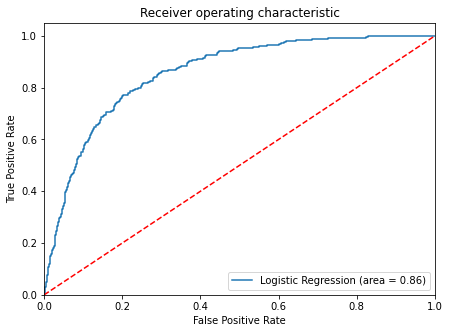

In [131]:
#Plotting the AUC-ROC curse to see which threshold gives us the greatest gains
logit_roc_auc_train = roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [132]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.05883622676460012


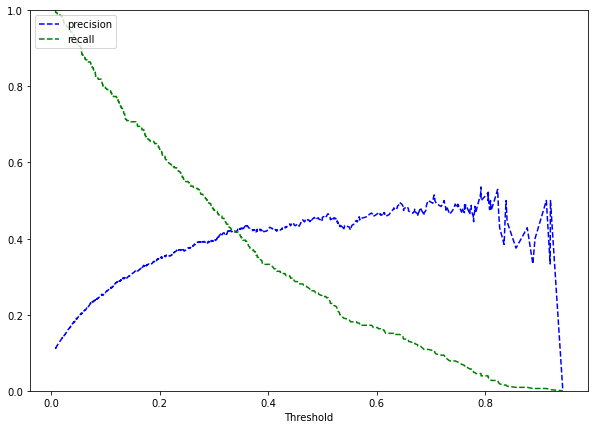

In [133]:
#Plotting precision to recall of the model
y_scores = logreg.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

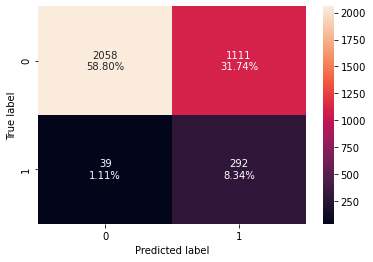

In [134]:
confusion_matrix_sklearn_with_threshold(logreg, X_train, y_train,threshold=0.05883622676460012)

In [135]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    logreg, X_train, y_train, threshold =0.05883622676460012
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.671429,0.882175,0.208125,0.336794


In [136]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    logreg, X_test, y_test, threshold =0.05883622676460012
)

print("Testing performance:")
log_reg_model_train_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.655333,0.872483,0.207006,0.33462


87% Recall isn't bad but that accuracy is trash. Let's see if we can improve the model through hyperparameter search then sequential feature selection.

### Hyperparameter search

In [137]:
def optimal_threshold_model(model):
    #We have to search for thresholds while checking the other hyperparameters. This will do that.
    fpr,tpr,thresholds = metrics.roc_curve(y_test,model.predict_proba(X_train)[:,1]) #was originally X_test
    optimal_idx=np.argmax(tpr-fpr)
    optimal_threshold_auc_roc=thresholds[optimal_idx]
    return optimal_threshold_auc_roc

In [138]:
def get_metrics_score(model,train,test,train_y,test_y,threshold=0.5,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = (model.predict_proba(train)[:,1]>threshold)
    pred_test = (model.predict_proba(test)[:,1]>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    
    if flag == True:
        print("-"*50)
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        
        print("-"*50)
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        
        print("-"*50)
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        
        print("-"*50)
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
        
        print("-"*50)
        print("Log Loss on Training: ", log_loss(train_y, pred_train.astype(float)))
   
    if roc == True:
        print("-"*50)
        print("ROC-AUC Score on training set : ",roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [139]:
#I'm going to check all hyperparameters to see which is best for the model.
train_score=[]
test_score=[]
solver_info=[]
class_info=[]
C_info=[]
threshold=[]

prec_train_score=[]
prec_test_score=[]

f1_train_score=[]
f1_test_score=[]

solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
class_weight=[None,'balanced']
C = [0.75,0.85,0.95,1] #[0.1, 0.2, 0.3, 0.4, 0.5...]


for i in solver:
    for j in C:
        for k in class_weight:
            
            model = LogisticRegression(random_state=1, class_weight=k, C = j,solver=i)  # changing values of solver

            model.fit(X_train, y_train)
            
            prob_recall_max=optimal_threshold_model(model)
            
            scores_solver = get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=prob_recall_max,flag=False,roc=False)
            
            train_score.append(round(scores_solver[2],4))
            test_score.append(round(scores_solver[3],4))
            
            prec_train_score.append(round(scores_solver[4],4))
            prec_test_score.append(round(scores_solver[5],4))
            
            f1_train_score.append(round(scores_solver[6],4))
            f1_test_score.append(round(scores_solver[7],4))
            
            
            threshold.append(prob_recall_max)

            solver_info.append(i)
            C_info.append(j)
            class_info.append(k)
            

In [140]:
#Putting the results into a dataframe so I can read it and pick the best.
i = np.arange(len(train_score))
resultDF = pd.DataFrame({'Solver': pd.Series(solver_info,index=i),'C Value' : pd.Series(C_info, index=i),\
                    'Class Weight' : pd.Series(class_info, index = i),\
                         'threshold' : pd.Series(threshold, index = i),\
                         'train_recall_scores' : pd.Series(train_score, index = i),
                   'test_recall_scores' : pd.Series(test_score, index = i), \
                         'train_precision_scores' : pd.Series(prec_train_score, index = i),\
                        'test_preccison_scores' : pd.Series(prec_test_score, index = i),\
                        'train_f1_scores' : pd.Series(f1_train_score, index = i),\
                        'test_f1_scores' : pd.Series(f1_test_score, index = i)})

resultDF.head()

,Solver,C Value,Class Weight,threshold,train_recall_scores,test_recall_scores,train_precision_scores,test_preccison_scores,train_f1_scores,test_f1_scores
0,newton-cg,0.75,None,0.091236,0.9124,0.8591,0.4689,0.4904,0.6195,0.6244
1,newton-cg,0.75,balanced,0.370730,0.9486,0.9195,0.4266,0.4241,0.5886,0.5805
2,newton-cg,0.85,None,0.089160,0.9124,0.8591,0.4660,0.4885,0.6170,0.6229
3,newton-cg,0.85,balanced,0.367213,0.9486,0.9195,0.4255,0.4228,0.5875,0.5793
4,newton-cg,0.95,None,0.077793,0.9305,0.8792,0.4451,0.4533,0.6022,0.5982


In [141]:
#Recall is most important, I'm going to max it.
resultDF[resultDF['test_recall_scores']==resultDF['test_recall_scores'].max()]

,Solver,C Value,Class Weight,threshold,train_recall_scores,test_recall_scores,train_precision_scores,test_preccison_scores,train_f1_scores,test_f1_scores
5,newton-cg,0.95,balanced,0.337956,0.9517,0.9262,0.4003,0.4107,0.5635,0.5691
7,newton-cg,1.00,balanced,0.337670,0.9517,0.9262,0.3992,0.4107,0.5625,0.5691
17,liblinear,0.75,balanced,0.361275,0.9547,0.9262,0.3970,0.4071,0.5608,0.5656
21,liblinear,0.95,balanced,0.355097,0.9547,0.9262,0.3960,0.4071,0.5598,0.5656
23,liblinear,1.00,balanced,0.352598,0.9547,0.9262,0.3960,0.4035,0.5598,0.5621


In [142]:
model = LogisticRegression(solver='newton-cg',n_jobs=-1,random_state=1,C=.95,class_weight='balanced')
model.fit(X_train,y_train)
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    model, X_test, y_test, threshold =0.337956
)

print("Testing performance:")
log_reg_model_train_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.861333,0.932886,0.412463,0.572016


#### Training Performance

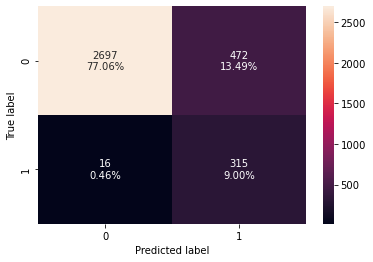

In [143]:
confusion_matrix_sklearn_with_threshold(model,
                                        X_train,
                                        y_train,threshold=0.337956) 
#Using thresh found per AOC-Curve above

In [144]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    model, X_train, y_train, threshold =0.337956
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.860571,0.951662,0.400254,0.563506


#### Test Performance

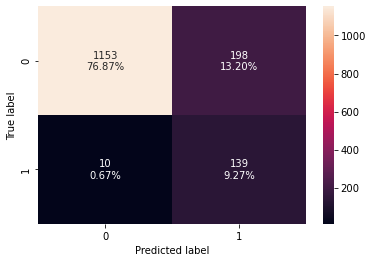

In [145]:
confusion_matrix_sklearn_with_threshold(model,
                                        X_test,
                                        y_test,threshold=0.337956) 
#Using thresh found per AOC-Curve above

In [146]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    model, X_test, y_test, threshold =0.337956
)

print("Testing performance:")
log_reg_model_train_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.861333,0.932886,0.412463,0.572016


We saw a huge boost to accuracy and a boost to recall and precision too. This model is much better. Let's see what coefficients were best.

In [147]:
log_odds = model.coef_[0]
pd.DataFrame(log_odds, X_test.columns, columns=["coef"]).sort_values(by='coef',ascending=False)

,coef
CD_Account,3.466950
CCavg_log10,2.930094
Education,1.356223
County_logreg_Santa Barbara County,0.502606
Family_Three,0.424423
County_logreg_Other,0.375764
County_logreg_Sacramento County,0.338393
County_logreg_Los Angeles County,0.313929
County_logreg_San Diego County,0.216956
County_logreg_Santa Clara County,0.188762


We'll talk more about that in the conclusions section.

Now let's see if tinkering with the number of features will help as well.

### Sequential Feature Selection

In [148]:
def custom_metrics_score(y_actual, y_prob):
    '''
    This is a custom defined function that is wrapped using make_scorer later on and passed as an input to SFS.
    '''
    # defining an empty list to store train and test results
    
    threshold=0.3237
    
    pred_train = (y_prob > threshold)
    

    pred_train = np.round(pred_train)
    
    train_f1 = f1_score(y_actual, pred_train) #We're using f1 here to see if we can get a good balance of accuracy and recall
    
#     print(train_recall)
    
    return train_f1

In [149]:
thres_scorer = make_scorer(score_func=custom_metrics_score, greater_is_better=True,needs_proba=True)

thres_scorer

make_scorer(custom_metrics_score, needs_proba=True)

In [150]:
# Fit the model on train using the hyperparameters we found before.
model_sfs = LogisticRegression(solver='newton-cg',n_jobs=-1,random_state=1,C=0.95, class_weight="balanced")

# we will first build model with all varaible
sfs = SFS(model_sfs, k_features=X_train.shape[1], forward=True, scoring=thres_scorer, verbose=2, cv=3)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   10.5s finished

[2021-09-04 10:10:11] Features: 1/23 -- score: 0.498151895176314[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.5s finished

[2021-09-04 10:10:13] Features: 2/23 -- score: 0.5075911835616554[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.6s finished

[2021-09-04 10:10:15] Features: 3/23 -- score: 0.5268371235698116[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

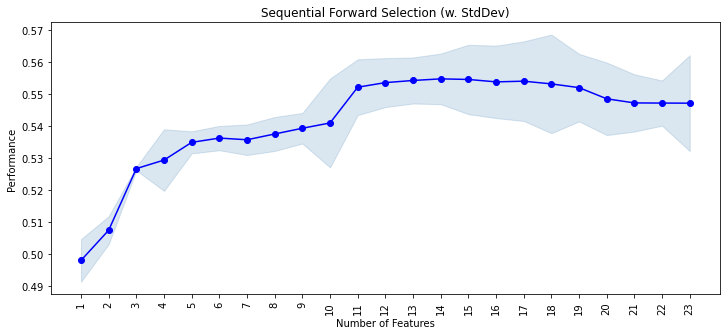

In [151]:
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev',figsize=(12,5))
# plt.ylim([0.85, 0.95])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xticks(rotation=90)
plt.show()

The highest recall is at 14 features. I'll run it again with that and extract the feature numbers, then make a new model using only those.

In [152]:
#Running the model again with 14 features to identify which features are the important ones
sfs = SFS(model_sfs, k_features=14, forward=True, scoring=thres_scorer, 
          verbose=0, #No verbose this time as I know the numbers
          cv=3) 

sfs = sfs.fit(X_train, y_train)

In [153]:
#This identifies the index numbers of the columns that were important features
feat_cols = list(sfs.k_feature_idx_)

In [154]:
#These are those numbers
feat_cols

[1, 2, 3, 4, 6, 7, 10, 11, 13, 17, 18, 20, 21, 22]

In [155]:
#Just curious which made it into the SFS. I'll look at coef later.
X_train.columns[feat_cols]

Index(['Income', 'Education', 'Securities_Account', 'CD_Account', 'CreditCard',
       'CCavg_log10', 'PopDense_sqrt', 'Family_One', 'Family_Two',
       'County_logreg_Sacramento County', 'County_logreg_San Diego County',
       'County_logreg_San Mateo County', 'County_logreg_Santa Barbara County',
       'County_logreg_Santa Clara County'],
      dtype='object')

In [156]:
#We remake the training and testing data using only those important columns
x_train_final = X_train[X_train.columns[feat_cols]]

# Creating new x_test with the same 14 variables that we selected for x_train
x_test_final = X_test[x_train_final.columns]

# Fitting model
log_reg_final_model = LogisticRegression(solver='newton-cg',n_jobs=-1,random_state=1,C=.95,class_weight='balanced')
# log_reg_final_model = LogisticRegression(solver='liblinear',n_jobs=-1,random_state=1,max_iter=20)
log_reg_final_model.fit(x_train_final, y_train)

LogisticRegression(C=0.95, class_weight='balanced', n_jobs=-1, random_state=1,
                   solver='newton-cg')

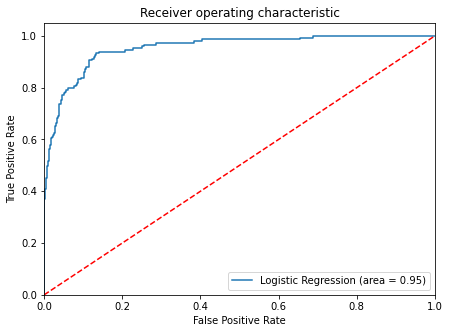

In [157]:
#Again finding the AUC-ROC curve to optimize our gains
logit_roc_auc_train = roc_auc_score(y_test, log_reg_final_model.predict_proba(x_test_final)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, log_reg_final_model.predict_proba(x_test_final)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [158]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_test, log_reg_final_model.predict_proba(x_test_final)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.37377413602807313


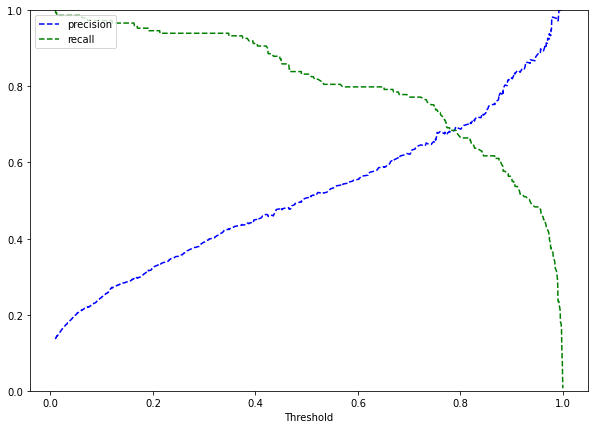

In [159]:
#Plotting precision and recall
y_scores = log_reg_final_model.predict_proba(x_test_final)[:, 1]
prec, rec, tre = precision_recall_curve(y_test, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

#### Training Performance

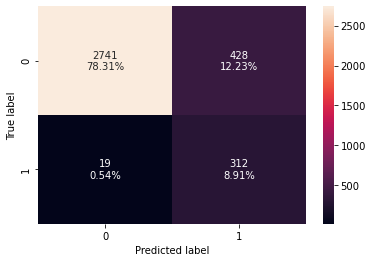

In [160]:
confusion_matrix_sklearn_with_threshold(log_reg_final_model,
                                        x_train_final,
                                        y_train,threshold=optimal_threshold_auc_roc) 
#Using thresh found per AOC-Curve above

In [161]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    log_reg_final_model, x_train_final, y_train, threshold =optimal_threshold_auc_roc
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.872286,0.942598,0.421622,0.582633


#### Test Performance

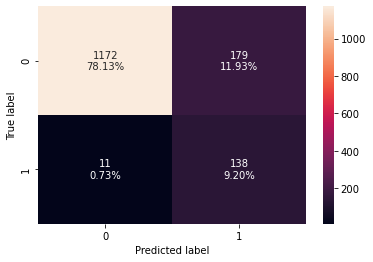

In [162]:
confusion_matrix_sklearn_with_threshold(log_reg_final_model,
                                        x_test_final,
                                        y_test,threshold=optimal_threshold_auc_roc) 
#Using thresh found per AOC-Curve above

In [163]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    log_reg_final_model, x_test_final, y_test, threshold =optimal_threshold_auc_roc
)

print("Testing performance:")
log_reg_model_train_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.873333,0.926174,0.435331,0.592275


In [164]:
#Getting coefficients of each of the features.
log_odds = log_reg_final_model.coef_[0]
pd.DataFrame(log_odds, x_test_final.columns, columns=["coef"]).sort_values(by='coef',ascending=False)

,coef
CD_Account,3.246830
CCavg_log10,2.868107
Education,1.349262
County_logreg_Santa Barbara County,0.192482
County_logreg_Sacramento County,0.183871
Income,0.053642
County_logreg_Santa Clara County,0.023057
PopDense_sqrt,0.002526
County_logreg_San Diego County,-0.068083
CreditCard,-0.861076


That's not a bad model, but cutting out the features gives us the disadvantage of no longer being able to see the effect most of the features have on prediction. If I got some decent gains I'd still use the SFS version, but .01 accuracy gain and a  loss of .0067 recall is nothing to write home about. Therefore, because recall is our primary judge of model quality and because I want to see the full suite of feature coefficients for analysis, I'm going to use the full hyperparameter-optimized model.

## Decision Tree Analysis

There were a lot of variables that were more suitable to a decision tree in the dataset. Because of that, we may find an even better model using a decision tree. First, let us split off the columns appropriate for use in a decision tree.

In [165]:
#Removing columns designed for the logistic regression. Decision trees don't care about skew.
df_Dtree = df.drop(['County_logreg','Mortgage_log10','CCavg_log10',],axis=1)

In [166]:
#Now converting the categorical variables to numbered categories so the tree can use them
df_Dtree['City_Code'] = df.City.cat.codes
df_Dtree['County_Code'] = df.County.cat.codes
df_Dtree['Family'] = data['Family']
#dropping duplicate columns
df_Dtree = df_Dtree.drop(['City','County'], axis=1)

In [167]:
#Double checking we got only what we wanted
df_Dtree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   float64
 1   Experience          5000 non-null   float64
 2   Income              5000 non-null   float64
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   float64
 7   Mortgage            5000 non-null   float64
 8   Personal_Loan       5000 non-null   float64
 9   Securities_Account  5000 non-null   float64
 10  CD_Account          5000 non-null   float64
 11  Online              5000 non-null   float64
 12  CreditCard          5000 non-null   float64
 13  Pop_Density         5000 non-null   float64
 14  Pop_Size            5000 non-null   float64
 15  PopDense_sqrt       5000 non-null   float64
 16  City_C

In [168]:
#Remove the dependent variable and make it y so we don't use it to predict itself.
X = df_Dtree.drop("Personal_Loan", axis=1) 
y = df_Dtree["Personal_Loan"]
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(3500, 17) (1500, 17)


In [169]:
#We want to see how imbalanced the df is so that we can set the class weights.
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts(normalize=False))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts(normalize=False))

Percentage of classes in training set:
0.0    0.905429
1.0    0.094571
Name: Personal_Loan, dtype: float64
0.0    3169
1.0     331
Name: Personal_Loan, dtype: int64
Percentage of classes in test set:
0.0    0.900667
1.0    0.099333
Name: Personal_Loan, dtype: float64
0.0    1351
1.0     149
Name: Personal_Loan, dtype: int64


That's very imbalanced. I'll put that in the class weight.

Now we run a gridsearch to find the best hyperparameters.

In [170]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight={0: 0.10, 1: 0.90})

# Grid of parameters to choose from
parameters = {
    "max_depth": [1,2,3,4,5,6,7,8,9,10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, criterion='entropy',
                       max_depth=2, min_impurity_decrease=1e-05,
                       random_state=1)

### Decision Tree Initial Performance

In [171]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [172]:
##  Function to calculate recall score
def get_recall_score(model, predictors, target):
    """
    model: classifier
    predictors: independent variables
    target: dependent variable
    
    """
    prediction = model.predict(predictors)
    return recall_score(target, prediction)

In [173]:
##  Function to calculate recall score on both testing and training simultaneously
def get_recall_score_simul(model):
    """
    model : classifier to predict values of X

    """
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
    print("Recall on test set : ", metrics.recall_score(y_test, pred_test))

#### Initial Dtree training performance

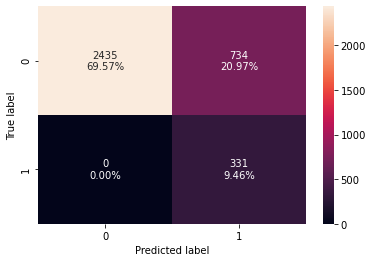

In [174]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [175]:
decision_tree_tune_perf_train = get_recall_score(estimator, X_train, y_train)
print("Recall Score:", decision_tree_tune_perf_train)

Recall Score: 1.0


#### Initial Dtree test performance

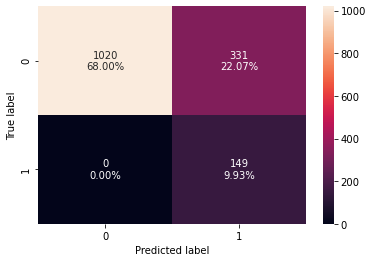

In [176]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [177]:
decision_tree_tune_perf_test = get_recall_score(estimator, X_test, y_test)
print("Recall Score:", decision_tree_tune_perf_test)
print("Training accuracy of best model: ", estimator.score(X_train, y_train))
print("Test accuracy of best model: ", estimator.score(X_test, y_test))

Recall Score: 1.0
Training accuracy of best model:  0.7902857142857143
Test accuracy of best model:  0.7793333333333333


A perfect recall is very desirable, however the .78 accuracy is quite low. Because the most important task at hand is creating an accurate profile for the marketing department to target, I would like the accuracy to be higher even if recall suffers a little bit. That way the feature importance is more likely to elucidate who the campaign worked on best.

### Visualizing the Dtree

In [178]:
## creating a list of column names
feature_names = X_train.columns.to_list()

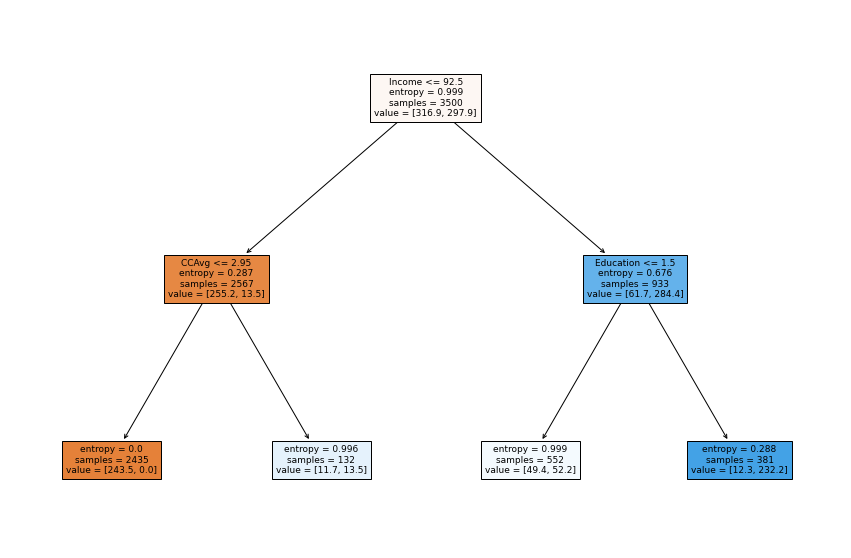

In [179]:
#Making a tree of the decision tree on the training set
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [180]:
#Assigning SHAP values to look at the relative importance of the features.
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_train)

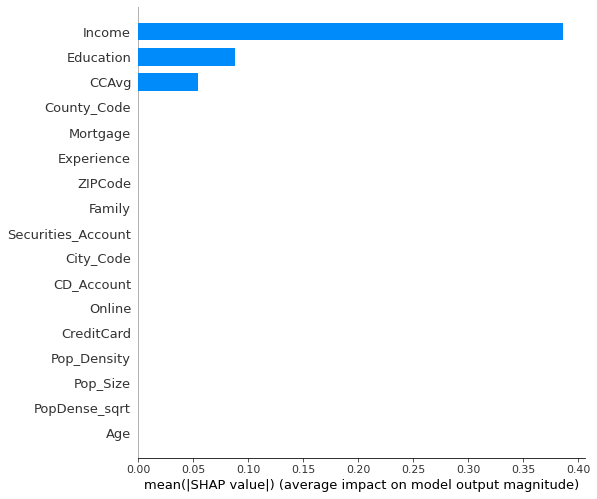

In [181]:
#Displaying feature importance according to SHAP values
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

To get perfect recall with a decision tree all we need is Income, Education, and CCAvg, with Income being the most important feature by far.

The accuracy of this decision tree is not great, though. Let's see if we can get a much better accuracy even if it means losing a little bit of recall.

## Refining the Dtree

I want to make another decision tree based on alpha values to see if I can boost accuracy without sacrificing much recall.

In [182]:
#Remaking the tree but removing some of the pre-pruning. We'll keep entropy since that was optimal.
dTree = DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, criterion='entropy', random_state=1)

path = dTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [183]:
#Finding alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.49298020194250414


In [184]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

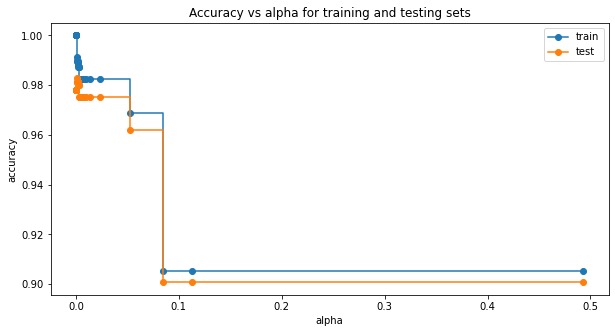

In [185]:
#Graphing alphas on test vs. train per alpha.
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [186]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print("Training accuracy of best model: ", best_model.score(X_train, y_train))
print("Test accuracy of best model: ", best_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=0.0007146217202631755, random_state=1)
Training accuracy of best model:  0.9914285714285714
Test accuracy of best model:  0.9826666666666667


In [187]:
#Getting recalls for train and test so I can plot them together
recall_train = []
for clf in clfs:
    pred_train3 = clf.predict(X_train)
    values_train = metrics.recall_score(y_train, pred_train3)
    recall_train.append(values_train)

In [188]:
recall_test = []
for clf in clfs:
    pred_test3 = clf.predict(X_test)
    values_test = metrics.recall_score(y_test, pred_test3)
    recall_test.append(values_test)

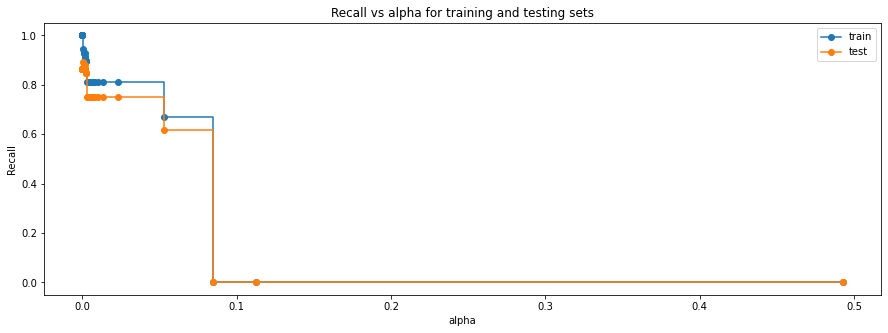

In [189]:
#Plotting recall on train vs. test for degrees of alpha
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [190]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0007146217202631755, random_state=1)


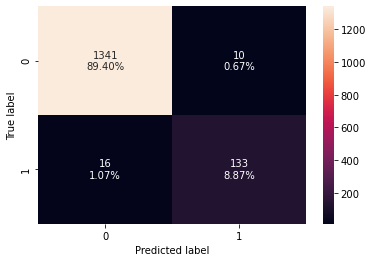

In [191]:
confusion_matrix_sklearn(best_model, X_test, y_test)

In [192]:
# Recall on train and test
get_recall_score_simul(best_model)

Recall on training set :  0.945619335347432
Recall on test set :  0.8926174496644296


In [193]:
print("Training accuracy of best model: ", best_model.score(X_train, y_train))
print("Test accuracy of best model: ", best_model.score(X_test, y_test))

Training accuracy of best model:  0.9914285714285714
Test accuracy of best model:  0.9826666666666667


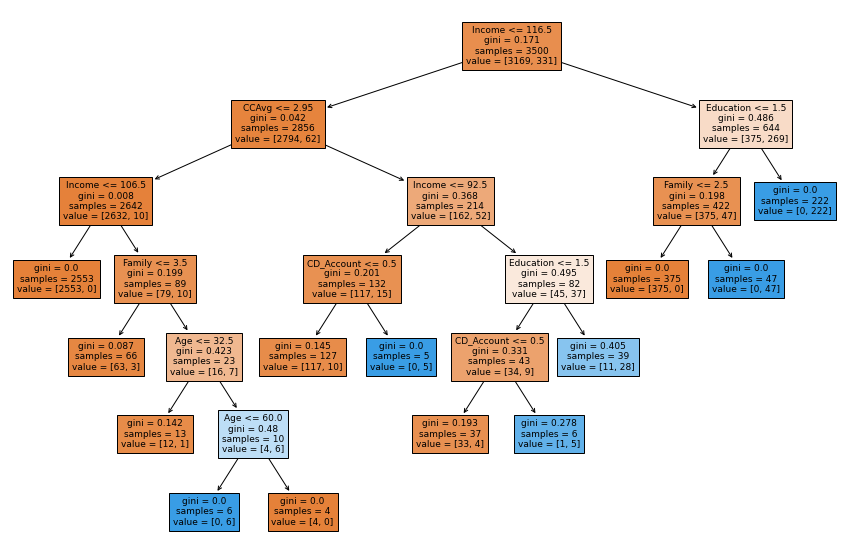

In [194]:
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [195]:
shap_values = shap.TreeExplainer(best_model).shap_values(X_test)

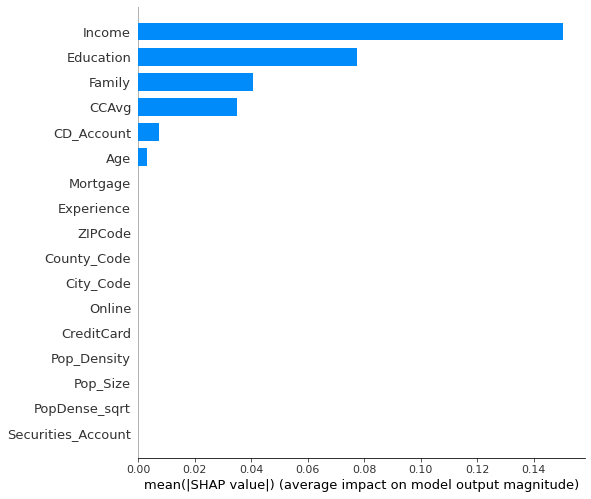

In [196]:
#SHAP values will tell us which of the features was most important to the decision tree.
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

A jump from .779 accuracy to .983 is well worth the slight drop in recall, in my opinion, because even with a drop from 1 to .89 this decision tree still has superb recall on the testing set, and it only uses six features: income, education, family, CCAvg, CD_Account, and age. This should serve as a very practical tool for marketing to identify new customers who will be responsive to the techniques used in the last marketing campaign. More on how to use this below.

# Recommendations 

## EDA Insights

Here is a summary of insights we gleamed from our EDA:

* People with higher incomes purchased more loans
* Those who spend more on their credit card were more responsive to last season's ad campaign.
* People who bought loans seem to make up a slightly larger concentration of those with larger families. 
* A MUCH larger proportion of those with a CD_Account bought a loan last campaign than didn't.
* Online should not influence whether they bought a loan last campaign or not.
* The proportion of those who bought a loan last campaign is about identical whether they use a credit card from another bank or not.
* The more education, the more likely they were to buy the loan.





## Decision tree conclusions

According to the decision tree, Income is the most important predictor for whether or not someone bought a personal loan last campaign. Its interaction with Education is most noteworthy.
* If the customer's income is greater than 116.5 and they had a graduate or advanced degree they were very likely to buy the loan, with these two conditions alone predicting 67% of purchases.
 * If the customer's income is that high and they only have a bachelor's degree, if they have 3 or more family members then this becomes 81% of purchases.
* General trends show that being more highly educated greatly increases the chance one purchased a loan.
* If a customer with less than 116.6 income does not have extremely high credit card spending habits (above 2.95k a month) they almost never purchased a loan. Only 6% of customers at that income level spend that high.
* For those customers with income less than 116.6 and high credit card spending, having a CD account becomes important. Marketing may want to target CDs to this group as an indirect method of slightly boosting personal loan sales. About 3% of personal loan sales were sold to customers of this group.

If the marketing team disagrees with me on my assessment on accuracy, or believes the costs so trivial that they prefer a 100% recall, they are free to use the simple decision tree that had perfect recall. If this is desired, here is how the logic goes:

97.5% of customers who buy a personal loan are those with an income higher than 92.5. That one factor alone will catch almost all true positives.
For the remaining 2.5%, if they have exceptionally high credit card spending (over 2.95k a month) they're more likely to buy a personal loan.

## Regression conclusions

According to the logistic regression model, we can make the following conclusions about last campaign's marketing strategy:

* If a customer has a CD account they were substantially more likely to buy a personal loan
* If the customer has a large family they were much more likely to buy a personal loan
* The more spending a customer had on their credit cards the more likely they were to buy a personal loan to a large degree
* More educated individuals were much more likely to buy personal loans
* If the customer either didn't have a credit card or only used our bank's credit card then they were much more likely to buy a personal loan
* If a customer used our credit card they were much more likely to buy a personal loan (1 in this case meant they used another bank's card, so the negative value meant they were more likely to buy a loan)
* If the customer had a securities account they were much less likely to buy a personal loan
* Our marketing strategies did not appeal evenly to the demographics of the counties in the dataset, San Mateo County was especially repulsed. We can draw some potential conclusions based on a demographic comparison between San Mateo - the most repulsed - and Santa Barbara - a county that was responsive to our personal loan campaign. California overall will be the baseline.
 * The education of San Mateo county is much higher than normal, which given Education's impact makes it seem like San Mateo would respond better to our personal loan campaign. Yet, this was not the case.
 * The average number of people per household in these counties is the same (2.9). Family size was not a factor in why these counties differ.
 * Notably, San Mateo county has almost double the proportion of Asians as California overall, and many fewer hispanics and whites. 
 * Santa Barbara, the least repelled of the important counties, has almost no Asians and a higher percentage of whites than normal. 
 * I hypothesize that the Asian population did not find the marketing appealing. Unfortunately, I do not have the data necessary to confirm this, so confirming this finding is beyond the scope of this project. Even so, this is the only major difference between these two counties according to census.gov that is not already accounted for in our regression model.
  * It could also be hypothesized that the lower hispanic population of San Mateo made a difference, but if we look at Sacramento County (another receptive county) we find a similar percentage of hispanics as San Mateo, so I find it unlikely.
  * It could also be hypothesized that foreign born percentage made a difference. However, in our EDA we saw that Montebello City had a huge proportion of loan purchasers, and yet they had a massive number of foreign born but no Asians.
  * In our EDA, Bella Vista and Oak View had enormous proportions of loan buyers, far more than the vast number of other cities. These two cities have 0% and 0.7% Asian populations, respectively.
  * Therefore, the support for Asians being turned off by our marketing strategy is quite strong. Either that or they just really don't like personal loans.
 
Overall I would recommend the following:

* The marketing team should confirm the demographic trends of those counties and, if true, find a marketing strategy that appeals more to Asians.
* The marketing team should promote our credit card. I encourage the marketing team to forward me data about how the credit card is marketed so that it can also be improved.
* Continue to use the previous campaign's strategy on customers who had a CD account with us and spent considerable sums on our credit card as it was highly effective on this group.
* Develop a new strategy to target single men and women and couples without children. Those with large families responded well to the previous campaign, but there is ample reason for singles and the childless to buy loans too. That the smaller family sizes were unimportant to the model is telling that we are missing out on this important demographic.
 * Noteworthy is that childless families and single parents with one child are in the same category in the dataset (Family = 2). I recommend to separate dependents from adults in future data collection to control for this. Having children changes lives more than basically any other factor.
* Don't use the same strategy as last campaign on those with a securities account. It didn't work.

## Final Remarks

Both the regression and the decision tree had similar recalls, but the decision tree had much better predictive accuracy overall. If we want to predict who would respond best to the campaign we did last time, I would use the decision tree to make that prediction.

However, this does not mean that the logistic regression does not come with important insights. I would be suspicious of it if it had conflicted with our insights from our EDA, but it did not. Without the regression I would not have been able to identify that we are potentially not reaching California's Asian population with our marketing.

I wish to remind the marketing team to not just double-down on those who responded well before. I recommend developing a new marketing strategy targeting other groups. A 9% conversion rate isn't bad, but it can be better. The easiest way to boost that number is to target people who were not responsive before.

Therefore, for every profile I generated, target the opposite of that. What about those with a high school education only? Only 33.9% of Californians have a bachelor's degree or higher. That's 66% of the population of California that never even entered our dataset. Why aren't they opening accounts? Why aren't they getting our credit card? Perhaps the bank should explore financial products that appeal to these demographics to get them into the system. After all, if we can get them using our credit card then it can be an excellent stepping stone for them buying a personal loan.


Here are some good groups to start with:

* Low income customers
* Single customers
* The high school educated
* Asians

Finally, remember that data analysis is garbage in, garbage out. The data was filled with errors and missing pieces of information, especially from the dictionary.

What does a 1 or a 0 value for CreditCard mean? Why does this variable fly in the face of common sense? In reality, almost everyone doesn't exclusively use our credit card.

What does a 1 or a 0 mean for Securities_Account? I had to assume 1 meant they had an account, but does it mean that?

This problem existed even for our target variable. I could have assumed the other direction, and defined 0 as them having purchased a loan. I didn't do this because I know we only had a 9% conversion rate, but these sorts of errors can happen if the dictionary is not compiled correctly.

Why do we have 70ish families living in a zipcode that only has 3 residents?

How were there negative values for Experience?

Please ensure future assignments come with detailed dictionaries.



